In [27]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set up plotting style
plt.style.use('default')  # Use default matplotlib style
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.grid'] = True
sns.set_palette("deep")  # Use seaborn's deep color palette

# Import project modules
import config.config as cfg
from src.data.preprocessing import (
    load_complaints_data, 
    filter_products, 
    preprocess_complaints,
    save_processed_data
)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [28]:
# Load the CFPB complaint dataset
print("Loading complaints data...")
df = load_complaints_data()

# Display basic information about the dataset
print("\nDataset Info:")
print("-" * 50)
print(f"Number of records: {len(df):,}")
print(f"Number of columns: {len(df.columns)}")

print("\nColumns:")
for col in df.columns:
    non_null = df[col].count()
    dtype = df[col].dtype
    print(f"- {col}: {non_null:,} non-null values ({dtype})")

# Print all column names with their index
print("\nAll columns in the dataset:")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

# Display first few rows
print("\nFirst few rows:")
display(df.head(1))

# Check if any column contains the word 'product' (case-insensitive)
product_cols = [col for col in df.columns if 'product' in col.lower()]
print("\nColumns containing 'product':", product_cols)


Loading complaints data...

Loaded 9,609,797 records with 18 columns

Dataset Info:
--------------------------------------------------
Number of records: 9,609,797
Number of columns: 18

Columns:
- Date received: 9,609,797 non-null values (object)
- Product: 9,609,797 non-null values (object)
- Sub-product: 9,374,502 non-null values (object)
- Issue: 9,609,791 non-null values (object)
- Sub-issue: 8,770,275 non-null values (object)
- Consumer complaint narrative: 2,980,756 non-null values (object)
- Company public response: 4,839,590 non-null values (object)
- Company: 9,609,797 non-null values (object)
- State: 9,555,281 non-null values (object)
- ZIP code: 9,579,569 non-null values (object)
- Tags: 628,768 non-null values (object)
- Consumer consent provided?: 7,960,236 non-null values (object)
- Submitted via: 9,609,797 non-null values (object)
- Date sent to company: 9,609,797 non-null values (object)
- Company response to consumer: 9,609,777 non-null values (object)
- Timely respo

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687



Columns containing 'product': ['Product', 'Sub-product']


Overall Product Distribution:
--------------------------------------------------

Top 10 products by number of complaints:
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                 

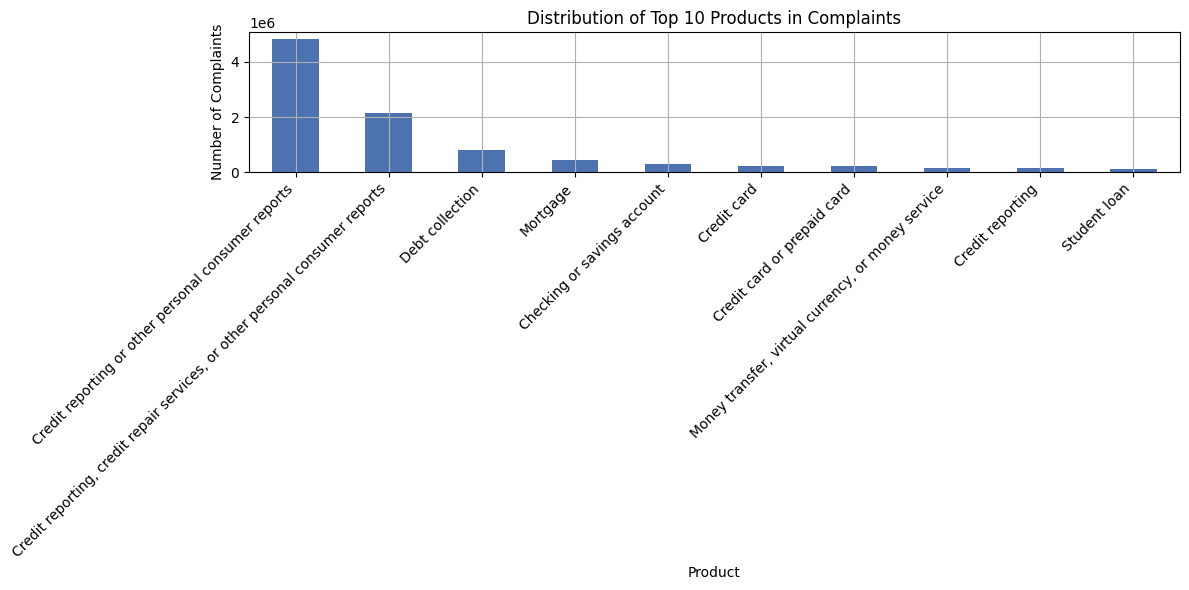


Target Product Categories:

Credit Cards:
  - Credit card: 226,686 complaints (2.4%)
  - Credit card or prepaid card: 206,369 complaints (2.1%)

Personal Loans:
  - Personal loan: 0 complaints (0.0%)
  - Consumer loan: 0 complaints (0.0%)
  - Payday loan: 5,541 complaints (0.1%)

Buy Now, Pay Later (BNPL):
  - Buy now, pay later: 0 complaints (0.0%)

Savings Accounts:
  - Checking or savings account: 291,178 complaints (3.0%)
  - Bank account or service: 86,205 complaints (0.9%)

Money Transfers:
  - Money transfer, virtual currency, or money service: 145,066 complaints (1.5%)

Filtering products...
Looking for the following categories:

Credit Cards:
  - Credit card
  - Credit card or prepaid card

Personal Loans:
  - Personal loan
  - Consumer loan
  - Payday loan

Buy Now, Pay Later (BNPL):
  - Buy now, pay later

Savings Accounts:
  - Checking or savings account
  - Bank account or service

Money Transfers:
  - Money transfer, virtual currency, or money service

Matched products d

<Figure size 1000x500 with 0 Axes>

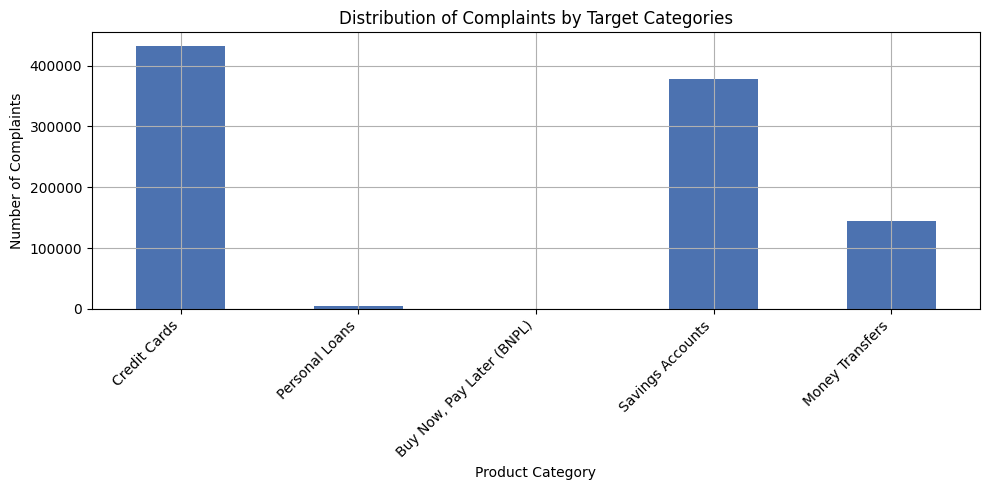

In [31]:
# Analyze overall product distribution
print("Overall Product Distribution:")
print("-" * 50)

# Get product distribution
product_counts = df['Product'].value_counts()
print("\nTop 10 products by number of complaints:")
print(product_counts.head(10))

# Plot distribution for top 10 products
plt.figure(figsize=(12, 6))
product_counts.head(10).plot(kind='bar')
plt.title('Distribution of Top 10 Products in Complaints')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show our target product categories
print("\nTarget Product Categories:")
for category, variations in cfg.PRODUCT_MAPPING.items():
    print(f"\n{category}:")
    for var in variations:
        count = product_counts.get(var, 0)
        percentage = (count / len(df)) * 100
        print(f"  - {var}: {count:,} complaints ({percentage:.1f}%)")

# Filter for our target products
df_filtered = filter_products(df)

# Visualize filtered products by our high-level categories
plt.figure(figsize=(10, 5))
category_counts = {}
for category, variations in cfg.PRODUCT_MAPPING.items():
    category_counts[category] = df_filtered[df_filtered['Product'].isin(variations)]['Product'].count()

# Plot the high-level categories
plt.figure(figsize=(10, 5))
pd.Series(category_counts).plot(kind='bar')
plt.title('Distribution of Complaints by Target Categories')
plt.xlabel('Product Category')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [32]:
# Process the complaints data
df_processed = preprocess_complaints(df_filtered)

print("\nSample of Cleaned Narratives:")
print("-" * 50)
sample_narratives = df_processed[['Consumer complaint narrative', 'clean_narrative']].head(3)
for i, row in sample_narratives.iterrows():
    print(f"\nOriginal: {row['Consumer complaint narrative'][:200]}...")
    print(f"\nCleaned: {row['clean_narrative'][:200]}...")
print("-" * 50)



Available columns in DataFrame:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']
Selected 11 columns for processing

Cleaning complaint narratives...
Retained 443,472 complaints with non-empty narratives

Sample of Cleaned Narratives:
--------------------------------------------------

Original: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut...

Cleaned: A REDACTED REDACTED card was opened under my name by a fraudster. I received a notice from REDACTED that an account was just opened under my name. I reached out to REDACTED REDACTED to state that this...

Origin

In [33]:
# Display sample narratives
print("\nSample of Cleaned Narratives:")
print("-" * 50)

# Make sure we're using the correct column names
narrative_col = 'Consumer complaint narrative'
sample_narratives = df_processed[[narrative_col, 'clean_narrative']].head(3)

# Display samples
for i, row in sample_narratives.iterrows():
    print(f"\nOriginal: {row[narrative_col][:200]}...")
    print(f"\nCleaned: {row['clean_narrative'][:200]}...")
print("-" * 50)



Sample of Cleaned Narratives:
--------------------------------------------------

Original: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut...

Cleaned: A REDACTED REDACTED card was opened under my name by a fraudster. I received a notice from REDACTED that an account was just opened under my name. I reached out to REDACTED REDACTED to state that this...

Original: I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outside their branch. 

I went into the branch and was told they couldn't help and had to phone the custo...

Cleaned: I made the mistake of using my wellsfargo debit card to depsit funds Into REDACTED ATM machine outside their branch. I went into the branch and was told they couldn't help and had to phone the custome...

Original: Dear CFPB, I have a secured credit card with citi

Narrative Text Analysis:
--------------------------------------------------

Narrative Length Statistics:
count   961045.000
mean       526.835
std       1025.973
min          0.000
25%          0.000
50%          0.000
75%        709.000
max      32785.000
Name: narrative_length, dtype: float64


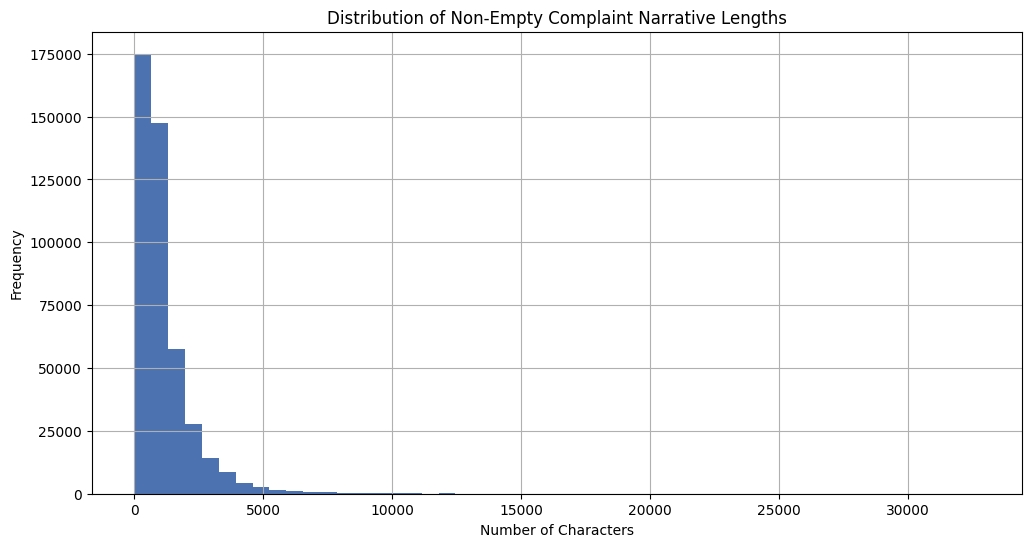


Narrative Statistics:
Total complaints: 961,045
Complaints with narratives: 443,472 (46.1%)
Complaints without narratives: 517,573 (53.9%)

Sample Narratives:
--------------------------------------------------

Narrative 1 (Length: 488 characters):
A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut...

Narrative 2 (Length: 555 characters):
I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outside their branch. 

I went into the branch and was told they couldn't help and had to phone the custo...

Narrative 3 (Length: 806 characters):
Dear CFPB, I have a secured credit card with citibank which is changed to unsecured card and I have been calling n waitting for the check release the secured amount {$2500.00} for rhat credit card. Th...

Average Narrative Length by Product Category:
-------------

In [34]:
# Analyze narrative text
print("Narrative Text Analysis:")
print("-" * 50)

# Get the narrative column name
narrative_col = 'Consumer complaint narrative'

# Calculate narrative lengths
df_filtered['narrative_length'] = df_filtered[narrative_col].fillna('').str.len()

# Basic statistics of narrative length
print("\nNarrative Length Statistics:")
print(df_filtered['narrative_length'].describe())

# Plot distribution of narrative lengths (excluding empty narratives)
plt.figure(figsize=(12, 6))
non_empty_lengths = df_filtered[df_filtered['narrative_length'] > 0]['narrative_length']
plt.hist(non_empty_lengths, bins=50)
plt.title('Distribution of Non-Empty Complaint Narrative Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Count complaints with and without narratives
has_narrative = df_filtered[narrative_col].notna().sum()
total_complaints = len(df_filtered)
print(f"\nNarrative Statistics:")
print(f"Total complaints: {total_complaints:,}")
print(f"Complaints with narratives: {has_narrative:,} ({has_narrative/total_complaints:.1%})")
print(f"Complaints without narratives: {total_complaints-has_narrative:,} ({(total_complaints-has_narrative)/total_complaints:.1%})")

# Show sample narratives
print("\nSample Narratives:")
print("-" * 50)
sample_narratives = df_filtered[df_filtered[narrative_col].notna()][narrative_col].head(3)
for i, narrative in enumerate(sample_narratives, 1):
    print(f"\nNarrative {i} (Length: {len(narrative)} characters):")
    print(narrative[:200] + "..." if len(narrative) > 200 else narrative)

# Additional analysis: Narrative length by product category
print("\nAverage Narrative Length by Product Category:")
print("-" * 50)
avg_lengths = df_filtered.groupby('Product')['narrative_length'].agg(['mean', 'count']).round(2)
avg_lengths = avg_lengths[avg_lengths['count'] > 0].sort_values('mean', ascending=False)
print(avg_lengths)


In [35]:
# Import the save_processed_data function
from src.data.preprocessing import save_processed_data

# Process the data
print("Processing complaints data...")
df_processed = preprocess_complaints(df_filtered)

# Display sample of cleaned narratives
print("\nSample of Cleaned Narratives:")
print("-" * 50)
narrative_col = 'Consumer complaint narrative'  # Use the correct column name
sample_narratives = df_processed[[narrative_col, 'clean_narrative']].head(3)
for i, row in sample_narratives.iterrows():
    print(f"\nOriginal: {row[narrative_col][:200]}...")
    print(f"Cleaned:  {row['clean_narrative'][:200]}...")

# Save the processed data
save_processed_data(df_processed)

print("\nProcessing Summary:")
print("-" * 50)
print(f"Original number of complaints: {len(df):,}")
print(f"Filtered complaints: {len(df_filtered):,}")
print(f"Final processed complaints: {len(df_processed):,}")


Processing complaints data...

Available columns in DataFrame:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narrative_length']
Selected 11 columns for processing

Cleaning complaint narratives...
Retained 443,472 complaints with non-empty narratives

Sample of Cleaned Narratives:
--------------------------------------------------

Original: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut...
Cleaned:  A REDACTED REDACTED card was opened under my name by a fraudster. I received a notice from REDACTED that an account was just opened under my name. I reached out 

Analysis of Processed Data:
--------------------------------------------------

Top Issues by Product:

Credit card:
Issue
Problem with a purchase shown on your statement                    14338
Problem with a company's investigation into an existing problem     7362
Getting a credit card                                               7253
Name: count, dtype: int64

Credit card or prepaid card:
Issue
Problem with a purchase shown on your statement    26159
Other features, terms, or problems                 12755
Fees or interest                                   11340
Name: count, dtype: int64

Personal loan:
Series([], Name: count, dtype: int64)

Consumer loan:
Series([], Name: count, dtype: int64)

Payday loan:
Issue
Charged fees or interest I didn't expect    752
Can't contact lender                        339
Received a loan I didn't apply for          202
Name: count, dtype: int64

Buy now, pay later:
Series([], Name: count, dtype: int64)

Checking or savings account:
Issue
Managi

<Figure size 1500x600 with 0 Axes>

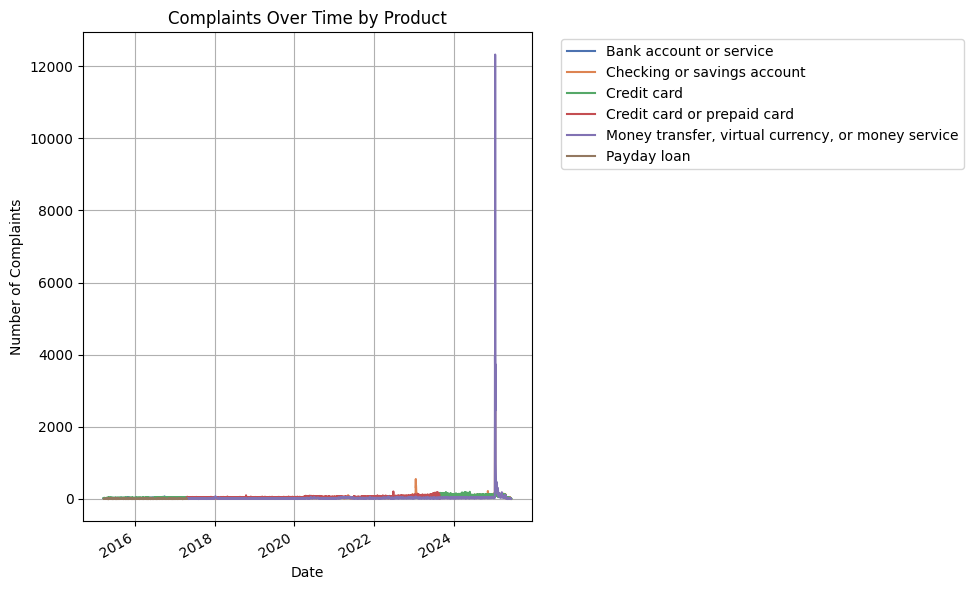


Company Response Analysis:
Company public response
Company has responded to the consumer and the CFPB and chooses not to provide a public response    156857
Company believes it acted appropriately as authorized by contract or law                            18933
Company chooses not to provide a public response                                                     5496
Company believes complaint is the result of an isolated error                                         509
Company believes complaint represents an opportunity for improvement to better serve consumers        440
                                                                                                    ...  
Company believes the complaint provided an opportunity to answer consumer's questions                 322
Company believes the complaint is the result of a misunderstanding                                    269
Company disputes the facts presented in the complaint                                               

In [36]:
# Import necessary constants
from config.config import PRODUCT_CATEGORIES

# Additional analysis of processed data
print("Analysis of Processed Data:")
print("-" * 50)

# Issues by product
print("\nTop Issues by Product:")
for product in PRODUCT_CATEGORIES:
    print(f"\n{product}:")
    print(df_processed[df_processed['Product'] == product]['Issue'].value_counts().head(3))

# Time series analysis
plt.figure(figsize=(15, 6))
df_processed.groupby(['Date received', 'Product']).size().unstack().plot()
plt.title('Complaints Over Time by Product')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Company response analysis
print("\nCompany Response Analysis:")
response_counts = df_processed['Company public response'].value_counts()
print(response_counts)

# Geographic distribution
print("\nTop 10 States by Number of Complaints:")
print(df_processed['State'].value_counts().head(10))


Product Distribution Analysis
--------------------------------------------------

Product Distribution:
Checking or savings account: 140,319 complaints (31.6%)
Credit card or prepaid card: 108,667 complaints (24.5%)
Money transfer, virtual currency, or money service: 97,188 complaints (21.9%)
Credit card: 80,667 complaints (18.2%)
Bank account or service: 14,885 complaints (3.4%)
Payday loan: 1,746 complaints (0.4%)


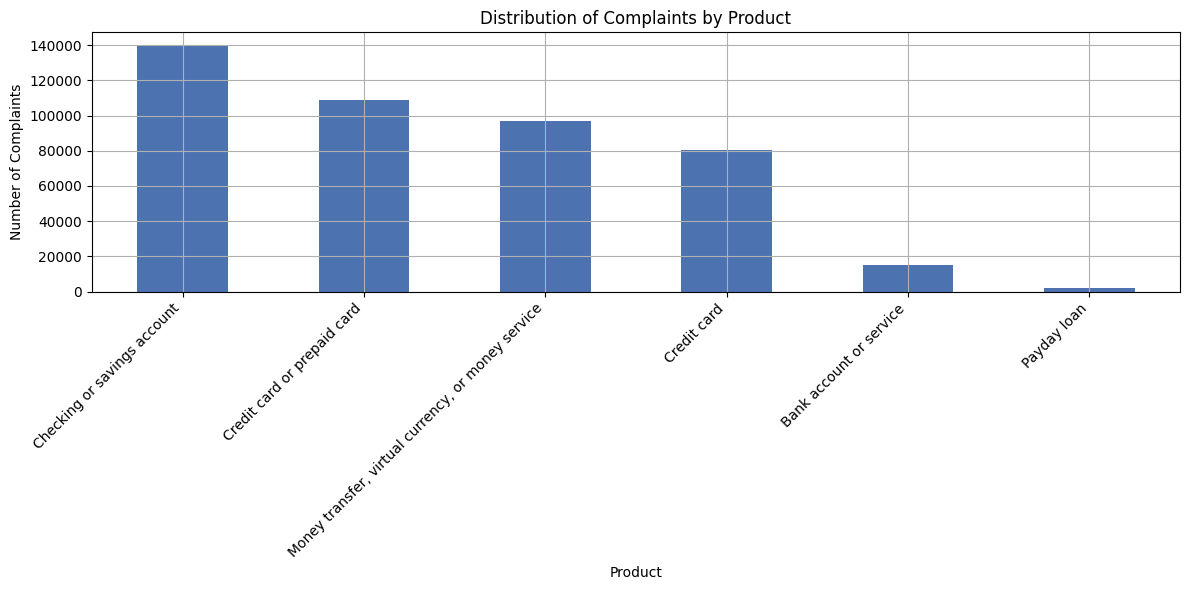


Top Sub-products by Product Category:
--------------------------------------------------

Credit card:
  - General-purpose credit card or charge card: 53,669 (66.5%)
  - Store credit card: 8,161 (10.1%)

Checking or savings account:
  - Checking account: 115,568 (82.4%)
  - Savings account: 11,359 (8.1%)
  - Other banking product or service: 11,056 (7.9%)
  - CD (Certificate of Deposit): 2,301 (1.6%)

Money transfer, virtual currency, or money service:
  - Domestic (US) money transfer: 56,316 (57.9%)
  - Mobile or digital wallet: 21,409 (22.0%)
  - Virtual currency: 9,637 (9.9%)
  - International money transfer: 5,714 (5.9%)
  - Check cashing service: 1,048 (1.1%)

Credit card or prepaid card:
  - General-purpose credit card or charge card: 83,526 (76.9%)
  - Store credit card: 15,502 (14.3%)
  - General-purpose prepaid card: 4,856 (4.5%)
  - Government benefit card: 3,661 (3.4%)
  - Gift card: 618 (0.6%)

Bank account or service:
  - Checking account: 10,113 (67.9%)
  - Other bank pr

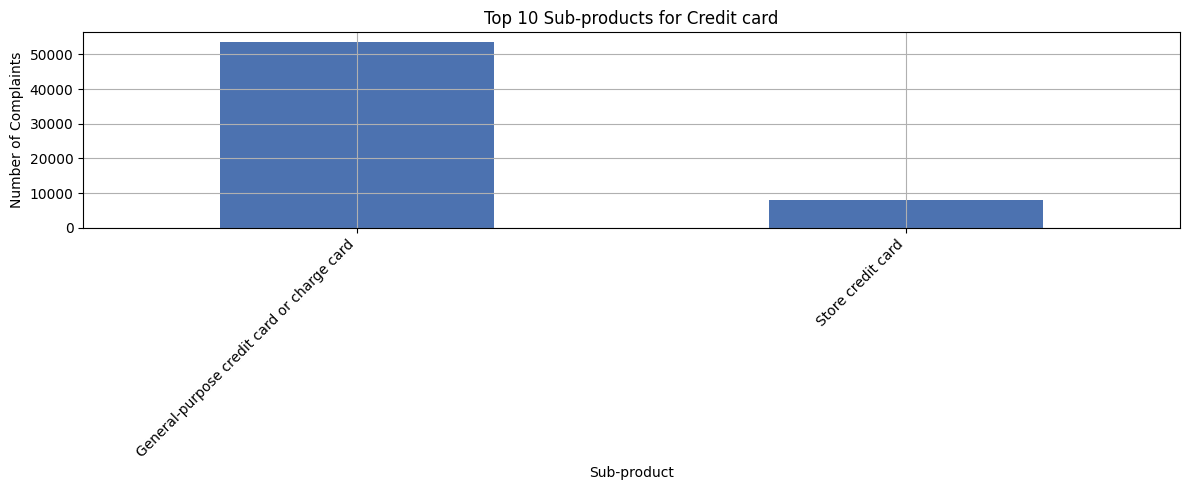

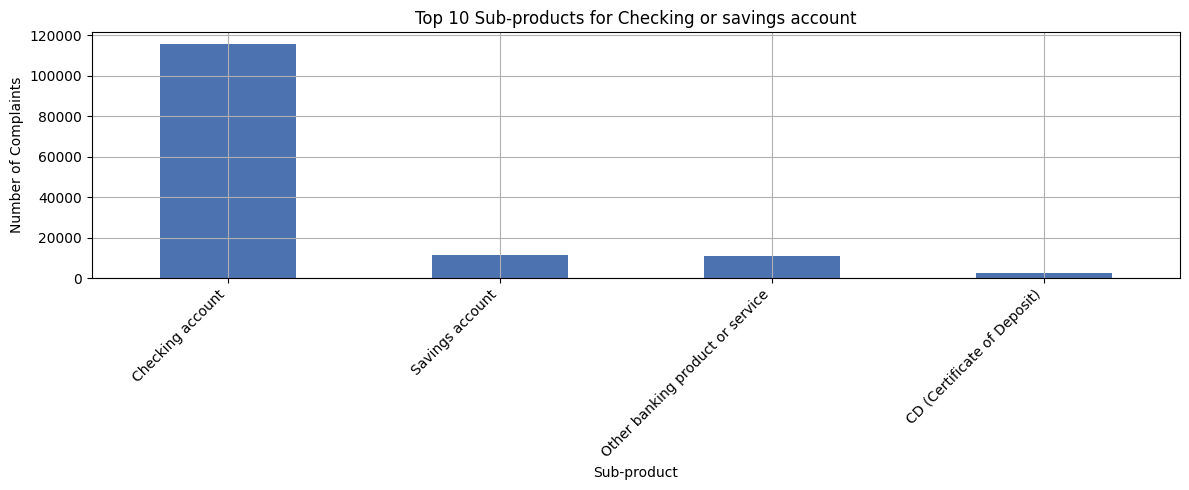

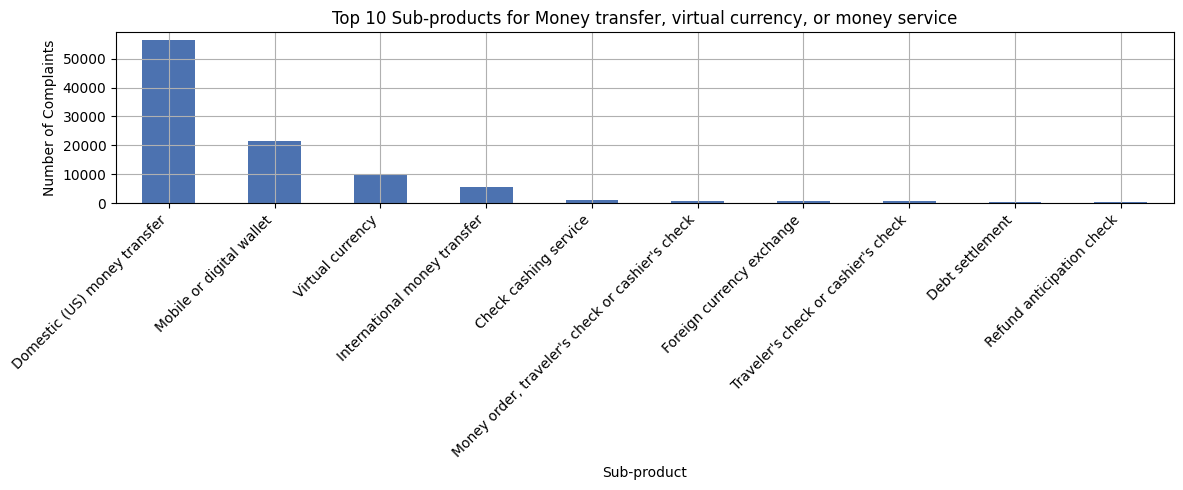

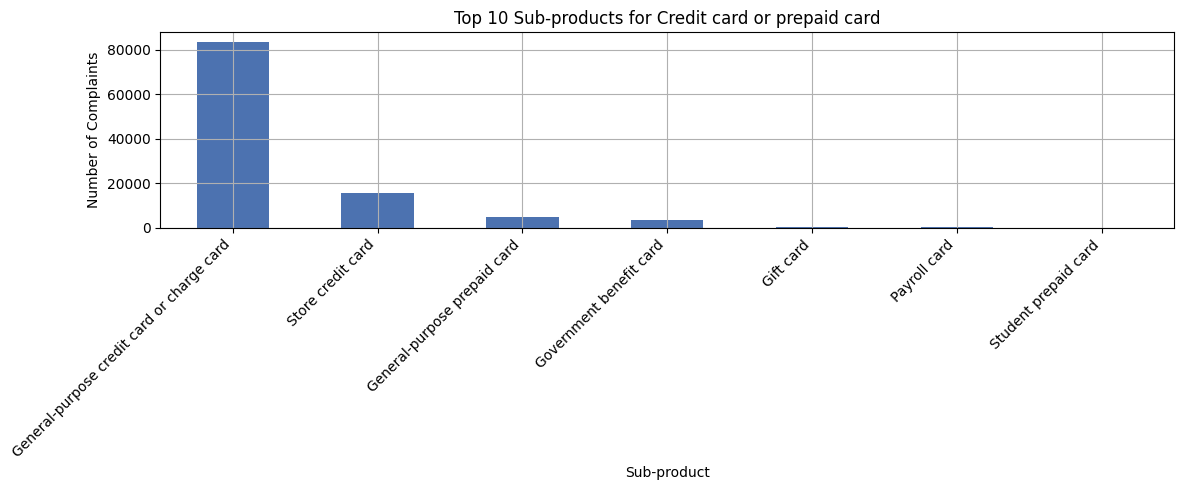

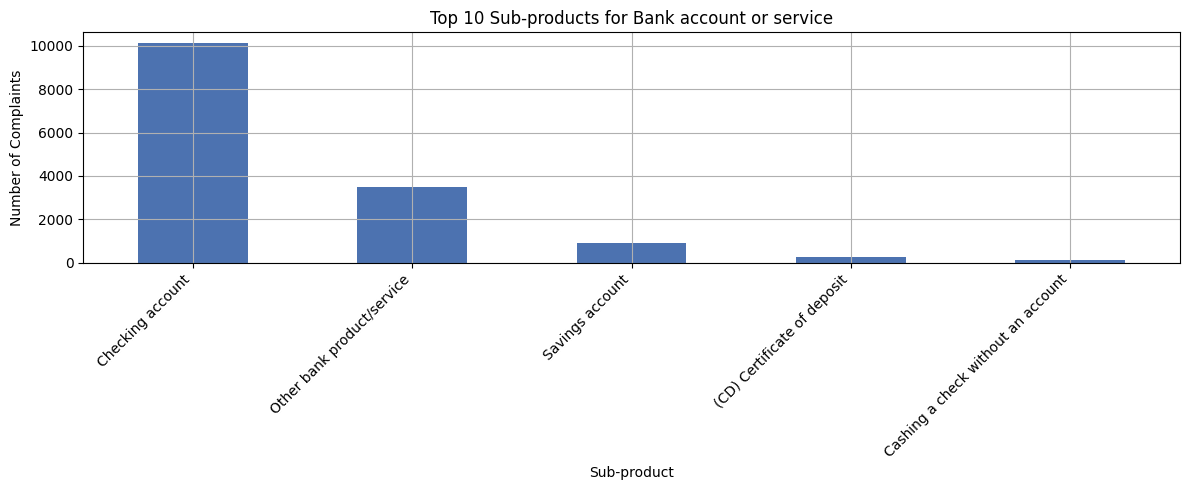


No sub-products to visualize for Payday loan


In [38]:
# Product Distribution Analysis
print("Product Distribution Analysis")
print("-" * 50)

# Overall product distribution
product_dist = df_processed['Product'].value_counts()
product_pct = df_processed['Product'].value_counts(normalize=True) * 100

print("\nProduct Distribution:")
for product, count in product_dist.items():
    pct = product_pct[product]
    print(f"{product}: {count:,} complaints ({pct:.1f}%)")

# Visualize product distribution
plt.figure(figsize=(12, 6))
product_dist.plot(kind='bar')
plt.title('Distribution of Complaints by Product')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sub-product analysis
print("\nTop Sub-products by Product Category:")
print("-" * 50)
for product in df_processed['Product'].unique():
    print(f"\n{product}:")
    subproduct_dist = df_processed[df_processed['Product'] == product]['Sub-product'].value_counts().head(5)
    if len(subproduct_dist) > 0:
        for subproduct, count in subproduct_dist.items():
            pct = (count / len(df_processed[df_processed['Product'] == product])) * 100
            print(f"  - {subproduct}: {count:,} ({pct:.1f}%)")
    else:
        print("  No sub-products found")

# Visualize sub-product distribution for each product
for product in df_processed['Product'].unique():
    subproduct_dist = df_processed[df_processed['Product'] == product]['Sub-product'].value_counts().head(10)
    
    # Only create plot if there are sub-products
    if len(subproduct_dist) > 0:
        plt.figure(figsize=(12, 5))
        subproduct_dist.plot(kind='bar')
        plt.title(f'Top 10 Sub-products for {product}')
        plt.xlabel('Sub-product')
        plt.ylabel('Number of Complaints')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nNo sub-products to visualize for {product}")


Issue Distribution Analysis
--------------------------------------------------

Top 10 Issues Overall:
Managing an account: 75,712 complaints (17.1%)
Other transaction problem: 49,431 complaints (11.1%)
Problem with a purchase shown on your statement: 40,497 complaints (9.1%)
Fraud or scam: 19,768 complaints (4.5%)
Other features, terms, or problems: 19,662 complaints (4.4%)
Closing an account: 19,217 complaints (4.3%)
Fees or interest: 18,028 complaints (4.1%)
Getting a credit card: 17,736 complaints (4.0%)
Problem with a lender or other company charging your account: 16,249 complaints (3.7%)
Problem caused by your funds being low: 15,597 complaints (3.5%)


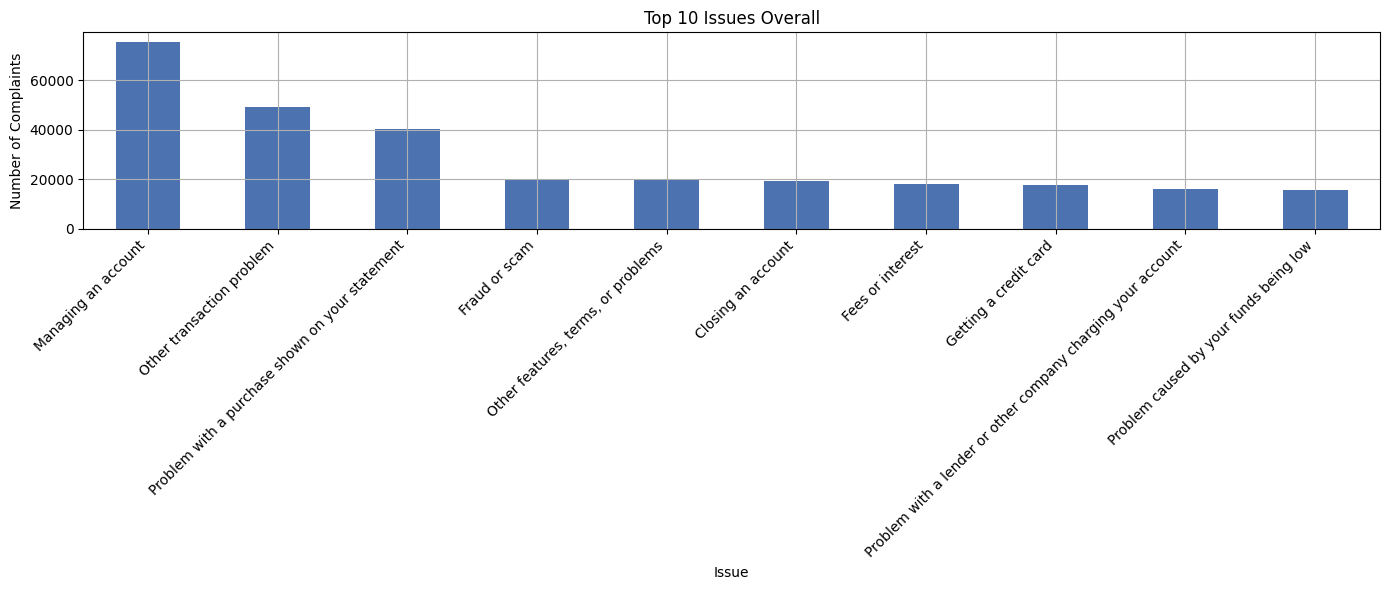


Top Issues by Product:
--------------------------------------------------

Credit card:
  - Problem with a purchase shown on your statement: 14,338 (17.8%)
  - Problem with a company's investigation into an existing problem: 7,362 (9.1%)
  - Getting a credit card: 7,253 (9.0%)
  - Other features, terms, or problems: 6,907 (8.6%)
  - Fees or interest: 6,688 (8.3%)


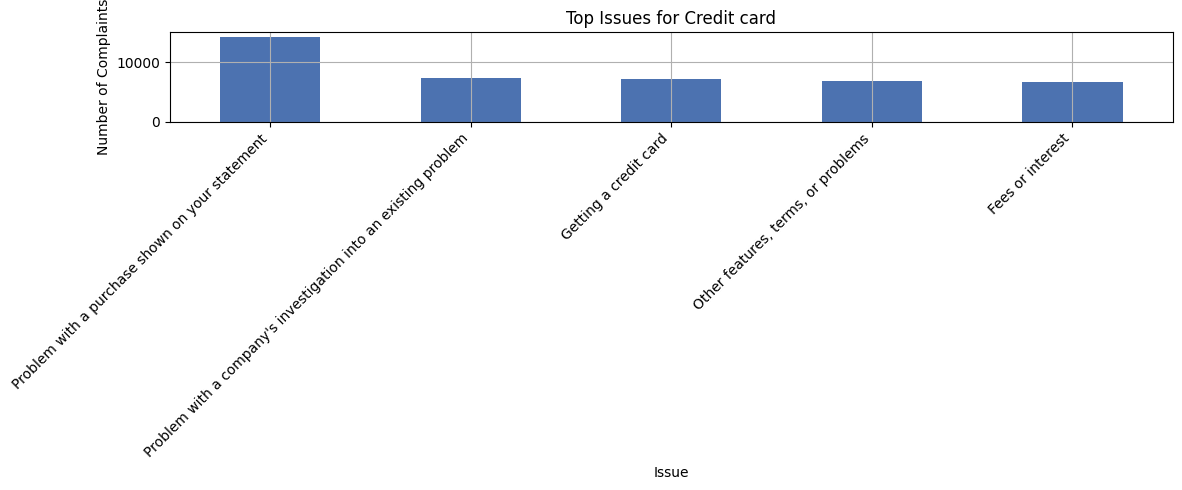


Checking or savings account:
  - Managing an account: 75,712 (54.0%)
  - Closing an account: 19,217 (13.7%)
  - Problem with a lender or other company charging your account: 16,249 (11.6%)
  - Problem caused by your funds being low: 15,597 (11.1%)
  - Opening an account: 12,836 (9.1%)


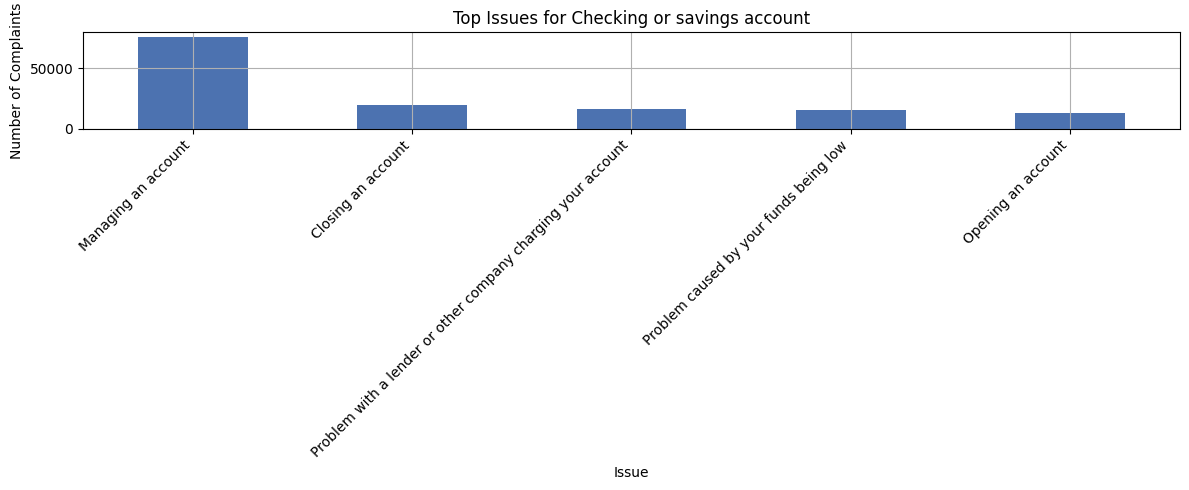


Money transfer, virtual currency, or money service:
  - Other transaction problem: 49,431 (50.9%)
  - Fraud or scam: 19,768 (20.3%)
  - Unauthorized transactions or other transaction problem: 6,009 (6.2%)
  - Money was not available when promised: 5,533 (5.7%)
  - Managing, opening, or closing your mobile wallet account: 4,652 (4.8%)


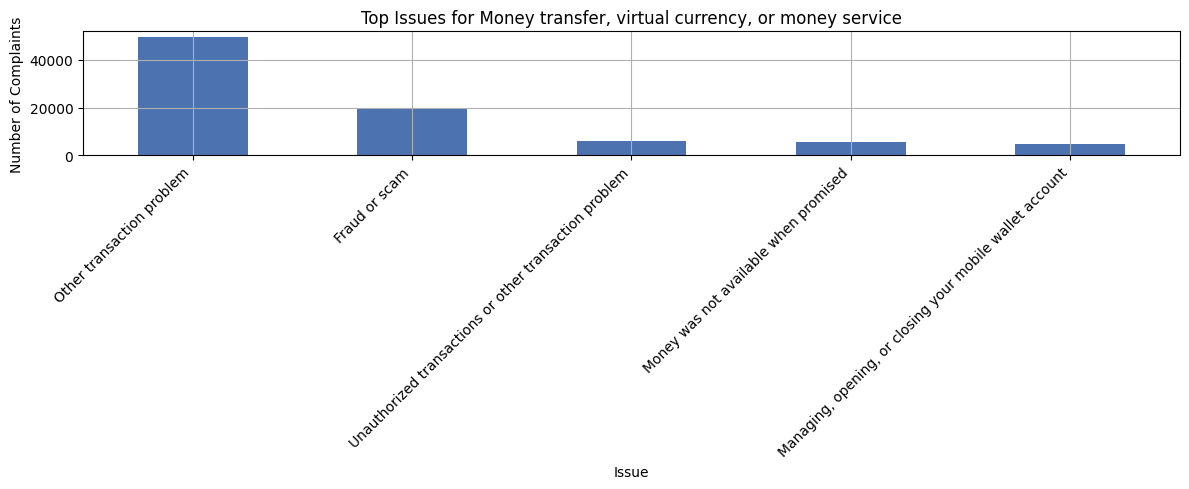


Credit card or prepaid card:
  - Problem with a purchase shown on your statement: 26,159 (24.1%)
  - Other features, terms, or problems: 12,755 (11.7%)
  - Fees or interest: 11,340 (10.4%)
  - Getting a credit card: 10,483 (9.6%)
  - Problem when making payments: 9,257 (8.5%)


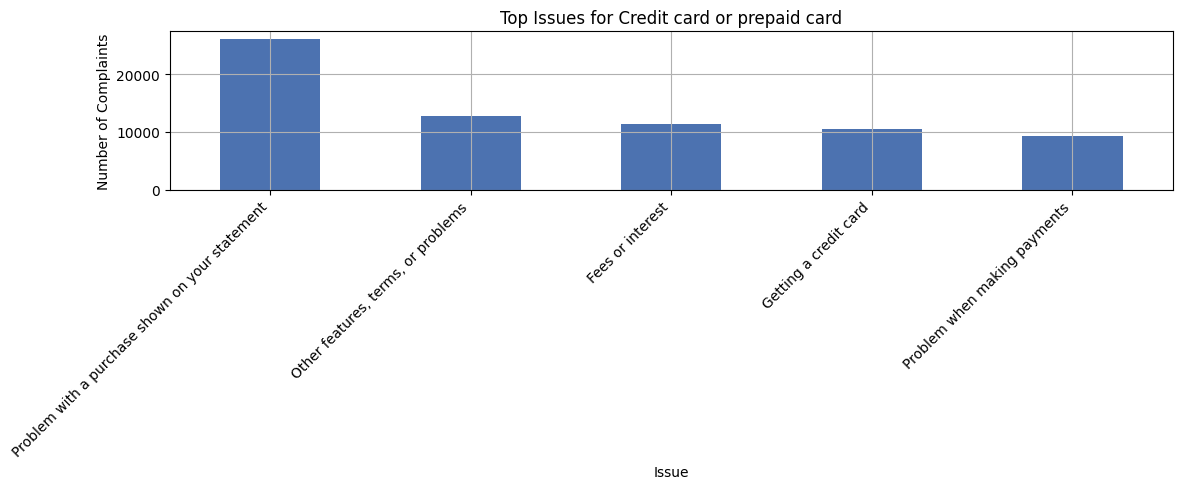


Bank account or service:
  - Account opening, closing, or management: 6,347 (42.6%)
  - Deposits and withdrawals: 3,425 (23.0%)
  - Problems caused by my funds being low: 2,084 (14.0%)
  - Using a debit or ATM card: 1,597 (10.7%)
  - Making/receiving payments, sending money: 1,432 (9.6%)


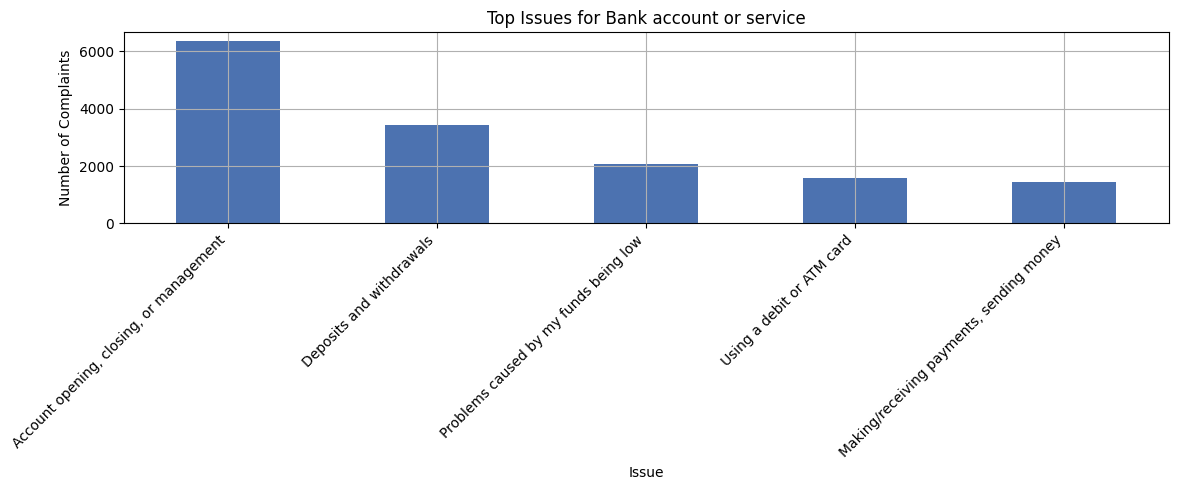


Payday loan:
  - Charged fees or interest I didn't expect: 752 (43.1%)
  - Can't contact lender: 339 (19.4%)
  - Received a loan I didn't apply for: 202 (11.6%)
  - Can't stop charges to bank account: 159 (9.1%)
  - Payment to acct not credited: 122 (7.0%)


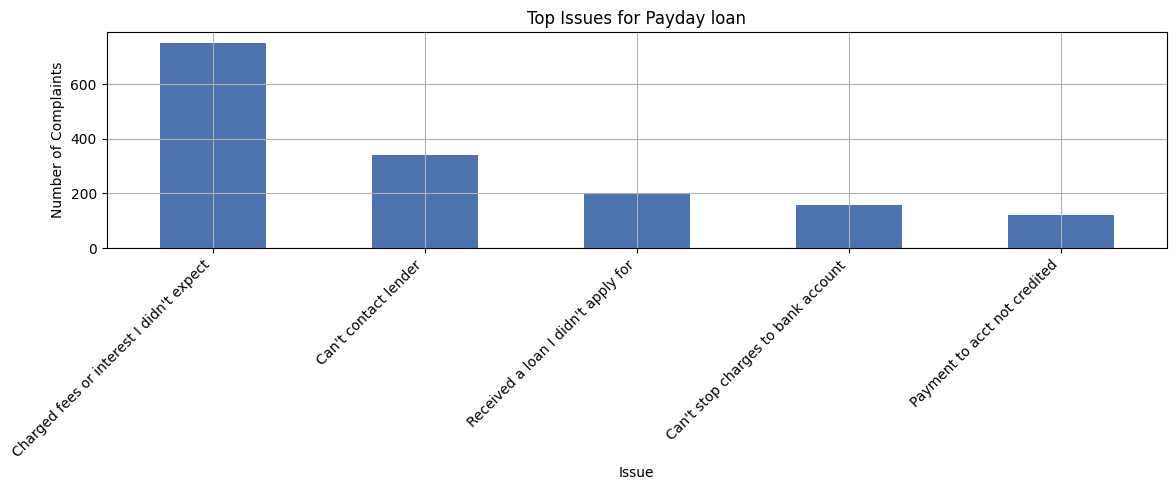

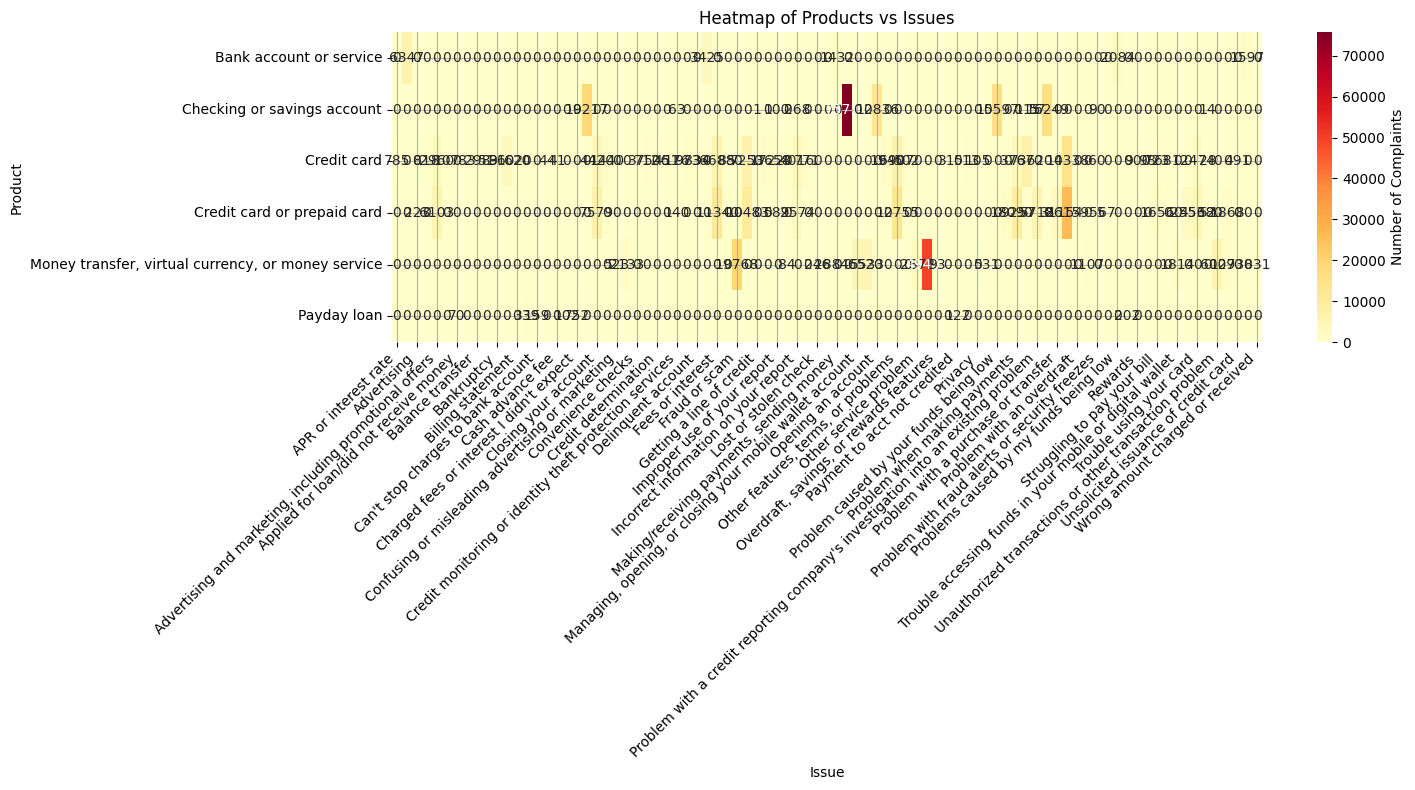

In [39]:
### 2.2 Issue Analysis

print("Issue Distribution Analysis")
print("-" * 50)

# Overall issue distribution
issue_dist = df_processed['Issue'].value_counts()
issue_pct = df_processed['Issue'].value_counts(normalize=True) * 100

print("\nTop 10 Issues Overall:")
for issue, count in issue_dist.head(10).items():
    pct = issue_pct[issue]
    print(f"{issue}: {count:,} complaints ({pct:.1f}%)")

# Visualize overall issue distribution
plt.figure(figsize=(14, 6))
issue_dist.head(10).plot(kind='bar')
plt.title('Top 10 Issues Overall')
plt.xlabel('Issue')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Issue distribution by product
print("\nTop Issues by Product:")
print("-" * 50)
for product in df_processed['Product'].unique():
    print(f"\n{product}:")
    product_issues = df_processed[df_processed['Product'] == product]['Issue'].value_counts().head(5)
    for issue, count in product_issues.items():
        pct = (count / len(df_processed[df_processed['Product'] == product])) * 100
        print(f"  - {issue}: {count:,} ({pct:.1f}%)")
    
    # Visualize issues for this product
    plt.figure(figsize=(12, 5))
    product_issues.plot(kind='bar')
    plt.title(f'Top Issues for {product}')
    plt.xlabel('Issue')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create a heatmap of Products vs Issues
pivot_table = pd.crosstab(df_processed['Product'], df_processed['Issue'])
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='d', cbar_kws={'label': 'Number of Complaints'})
plt.title('Heatmap of Products vs Issues')
plt.xlabel('Issue')
plt.ylabel('Product')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Temporal Analysis
--------------------------------------------------


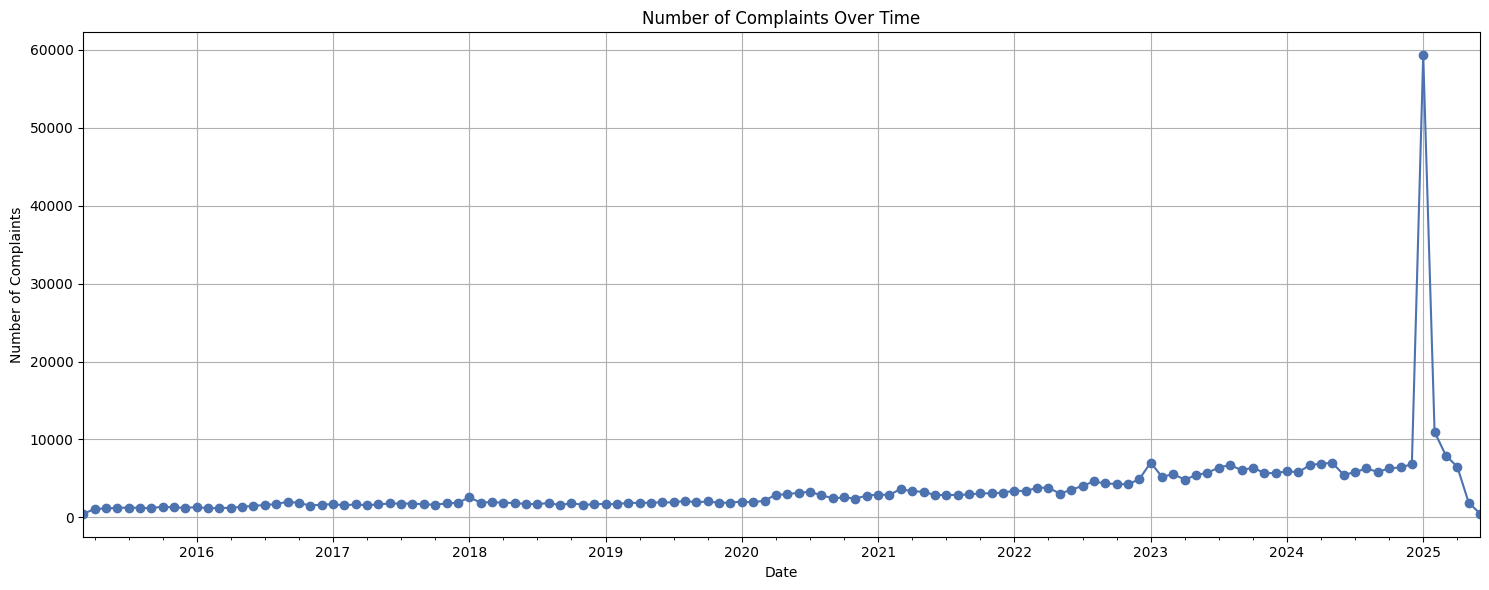


Complaints by Year:
2015: 11,417 complaints (2.6%)
2016: 18,055 complaints (4.1%)
2017: 20,395 complaints (4.6%)
2018: 22,094 complaints (5.0%)
2019: 22,716 complaints (5.1%)
2020: 31,460 complaints (7.1%)
2021: 36,974 complaints (8.3%)
2022: 47,420 complaints (10.7%)
2023: 70,671 complaints (15.9%)
2024: 75,189 complaints (17.0%)
2025: 87,081 complaints (19.6%)

Monthly Pattern (average across all years):
Month 1: 87,959 complaints (19.8%), +138.0% vs average
Month 2: 36,406 complaints (8.2%), -1.5% vs average
Month 3: 36,986 complaints (8.3%), +0.1% vs average
Month 4: 35,801 complaints (8.1%), -3.1% vs average
Month 5: 31,550 complaints (7.1%), -14.6% vs average
Month 6: 29,334 complaints (6.6%), -20.6% vs average
Month 7: 30,635 complaints (6.9%), -17.1% vs average
Month 8: 31,982 complaints (7.2%), -13.5% vs average
Month 9: 29,971 complaints (6.8%), -18.9% vs average
Month 10: 31,332 complaints (7.1%), -15.2% vs average
Month 11: 29,873 complaints (6.7%), -19.2% vs average
Month

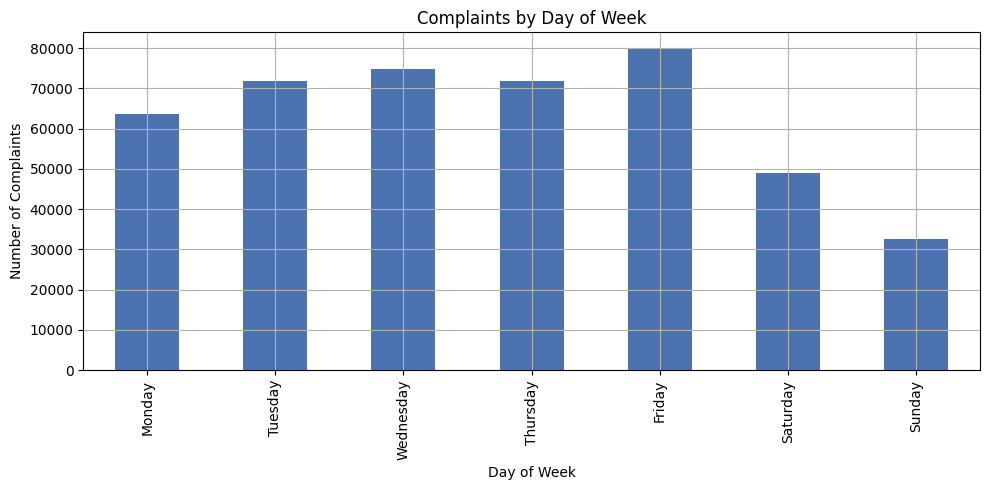

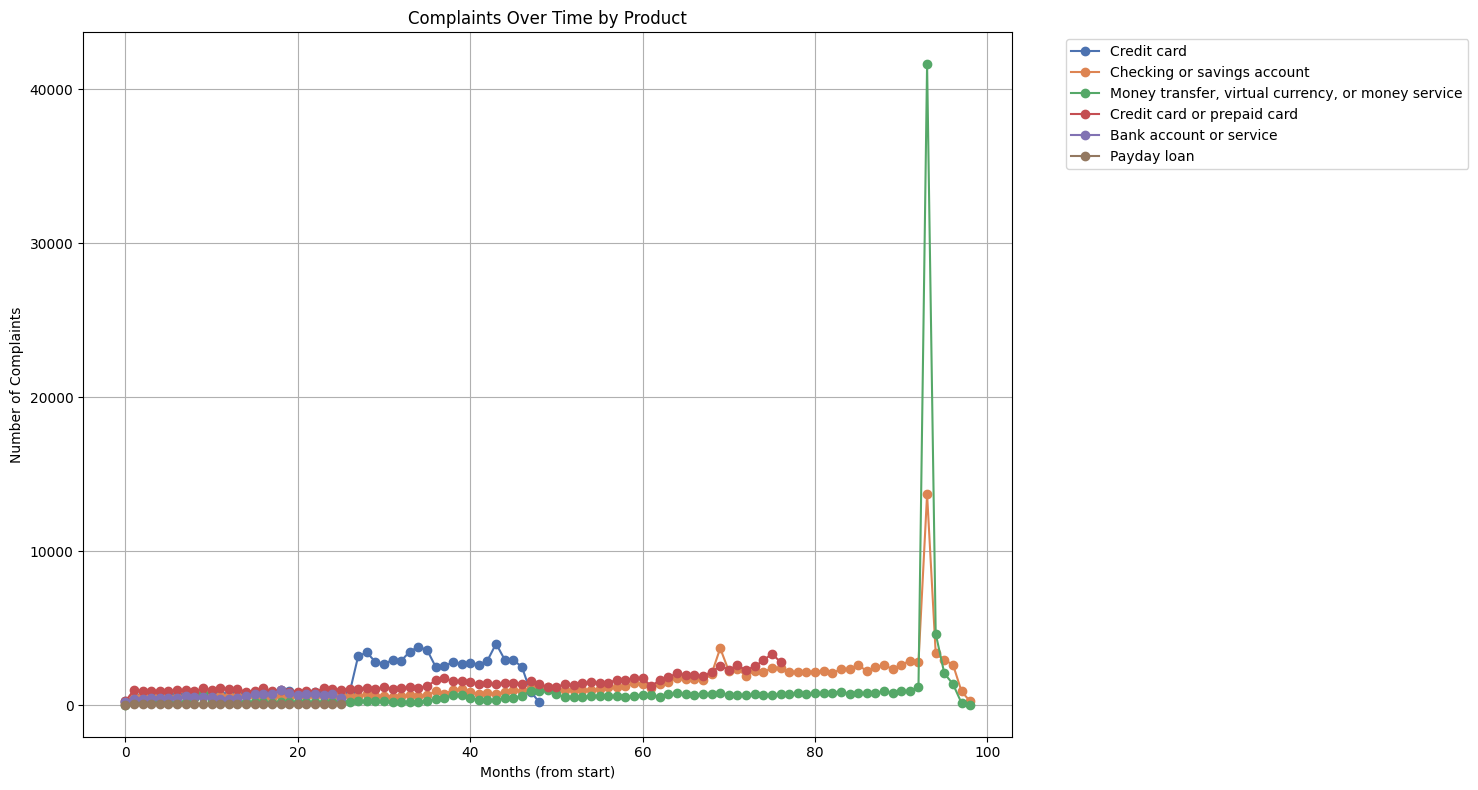

In [40]:
### 2.3 Temporal Analysis

print("Temporal Analysis")
print("-" * 50)

# Add datetime components
df_processed['Year'] = df_processed['Date received'].dt.year
df_processed['Month'] = df_processed['Date received'].dt.month
df_processed['Day'] = df_processed['Date received'].dt.day
df_processed['Weekday'] = df_processed['Date received'].dt.day_name()

# Complaints over time
monthly_complaints = df_processed.groupby([df_processed['Date received'].dt.to_period('M')]).size()

plt.figure(figsize=(15, 6))
monthly_complaints.plot(kind='line', marker='o')
plt.title('Number of Complaints Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.tight_layout()
plt.show()

# Complaints by year
yearly_complaints = df_processed.groupby('Year').size()
print("\nComplaints by Year:")
for year, count in yearly_complaints.items():
    pct = (count / len(df_processed)) * 100
    print(f"{year}: {count:,} complaints ({pct:.1f}%)")

# Complaints by month
monthly_avg = df_processed.groupby('Month').size().mean()
monthly_pattern = df_processed.groupby('Month').size()
print("\nMonthly Pattern (average across all years):")
for month, count in monthly_pattern.items():
    pct = (count / len(df_processed)) * 100
    vs_avg = ((count - monthly_avg) / monthly_avg) * 100
    print(f"Month {month}: {count:,} complaints ({pct:.1f}%), {vs_avg:+.1f}% vs average")

# Complaints by day of week
weekday_pattern = df_processed.groupby('Weekday').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(10, 5))
weekday_pattern.plot(kind='bar')
plt.title('Complaints by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Complaints')
plt.tight_layout()
plt.show()

# Time series by product
plt.figure(figsize=(15, 8))
for product in df_processed['Product'].unique():
    product_ts = df_processed[df_processed['Product'] == product].groupby([df_processed['Date received'].dt.to_period('M')]).size()
    plt.plot(range(len(product_ts)), product_ts, label=product, marker='o')

plt.title('Complaints Over Time by Product')
plt.xlabel('Months (from start)')
plt.ylabel('Number of Complaints')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Geographic and Response Analysis
--------------------------------------------------

Top 10 States by Number of Complaints:
CA: 60,860 complaints (13.9%)
TX: 39,175 complaints (8.9%)
FL: 39,081 complaints (8.9%)
NY: 32,475 complaints (7.4%)
IL: 23,513 complaints (5.4%)
GA: 21,345 complaints (4.9%)
PA: 16,711 complaints (3.8%)
NJ: 15,589 complaints (3.6%)
NC: 13,284 complaints (3.0%)
VA: 12,811 complaints (2.9%)


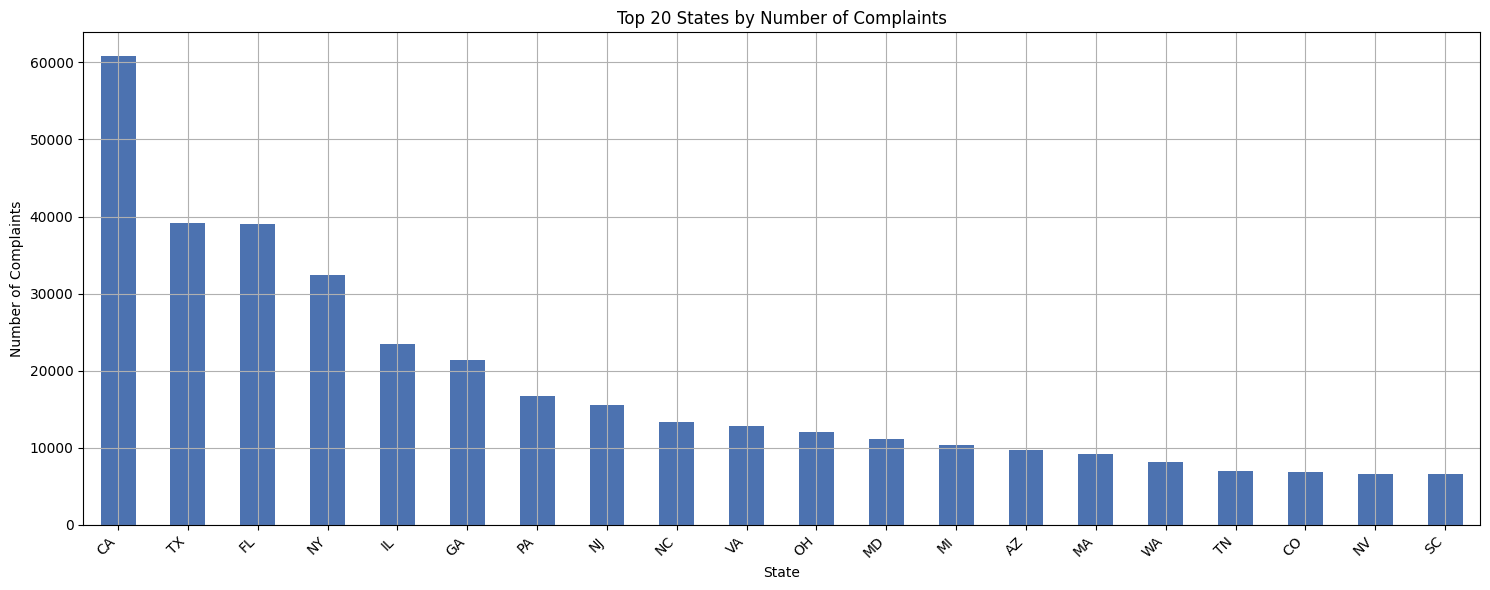


Company Response Distribution:
Company has responded to the consumer and the CFPB and chooses not to provide a public response: 156,857 responses (85.5%)
Company believes it acted appropriately as authorized by contract or law: 18,933 responses (10.3%)
Company chooses not to provide a public response: 5,496 responses (3.0%)
Company believes complaint is the result of an isolated error: 509 responses (0.3%)
Company believes complaint represents an opportunity for improvement to better serve consumers: 440 responses (0.2%)
Company believes complaint caused principally by actions of third party outside the control or direction of the company: 324 responses (0.2%)
Company believes the complaint provided an opportunity to answer consumer's questions: 322 responses (0.2%)
Company believes the complaint is the result of a misunderstanding: 269 responses (0.1%)
Company disputes the facts presented in the complaint: 215 responses (0.1%)
Company can't verify or dispute the facts in the complain

/var/folders/9c/z436vv391wd5csdhpxszxk600000gn/T/ipykernel_78550/1571884951.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


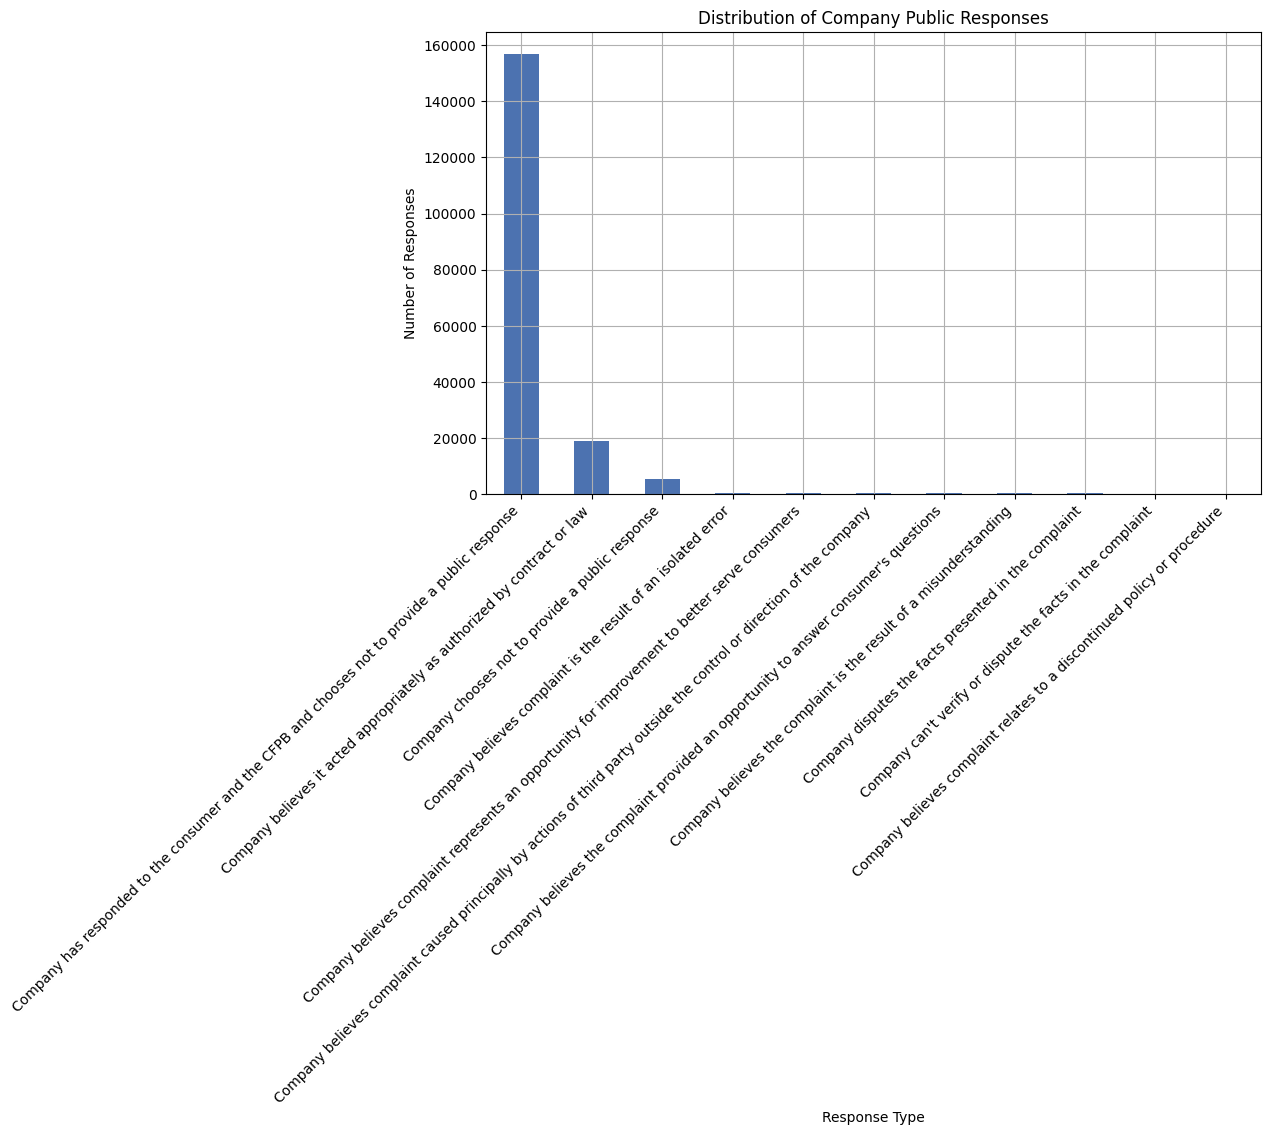


Response Distribution by Product:
--------------------------------------------------
Company public response                             Company believes complaint caused principally by actions of third party outside the control or direction of the company  \
Product                                                                                                                                                                       
Bank account or service                                                                         0.120                                                                         
Checking or savings account                                                                     0.100                                                                         
Credit card                                                                                     0.030                                                                         
Credit card or prepaid card            

/var/folders/9c/z436vv391wd5csdhpxszxk600000gn/T/ipykernel_78550/1571884951.py:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


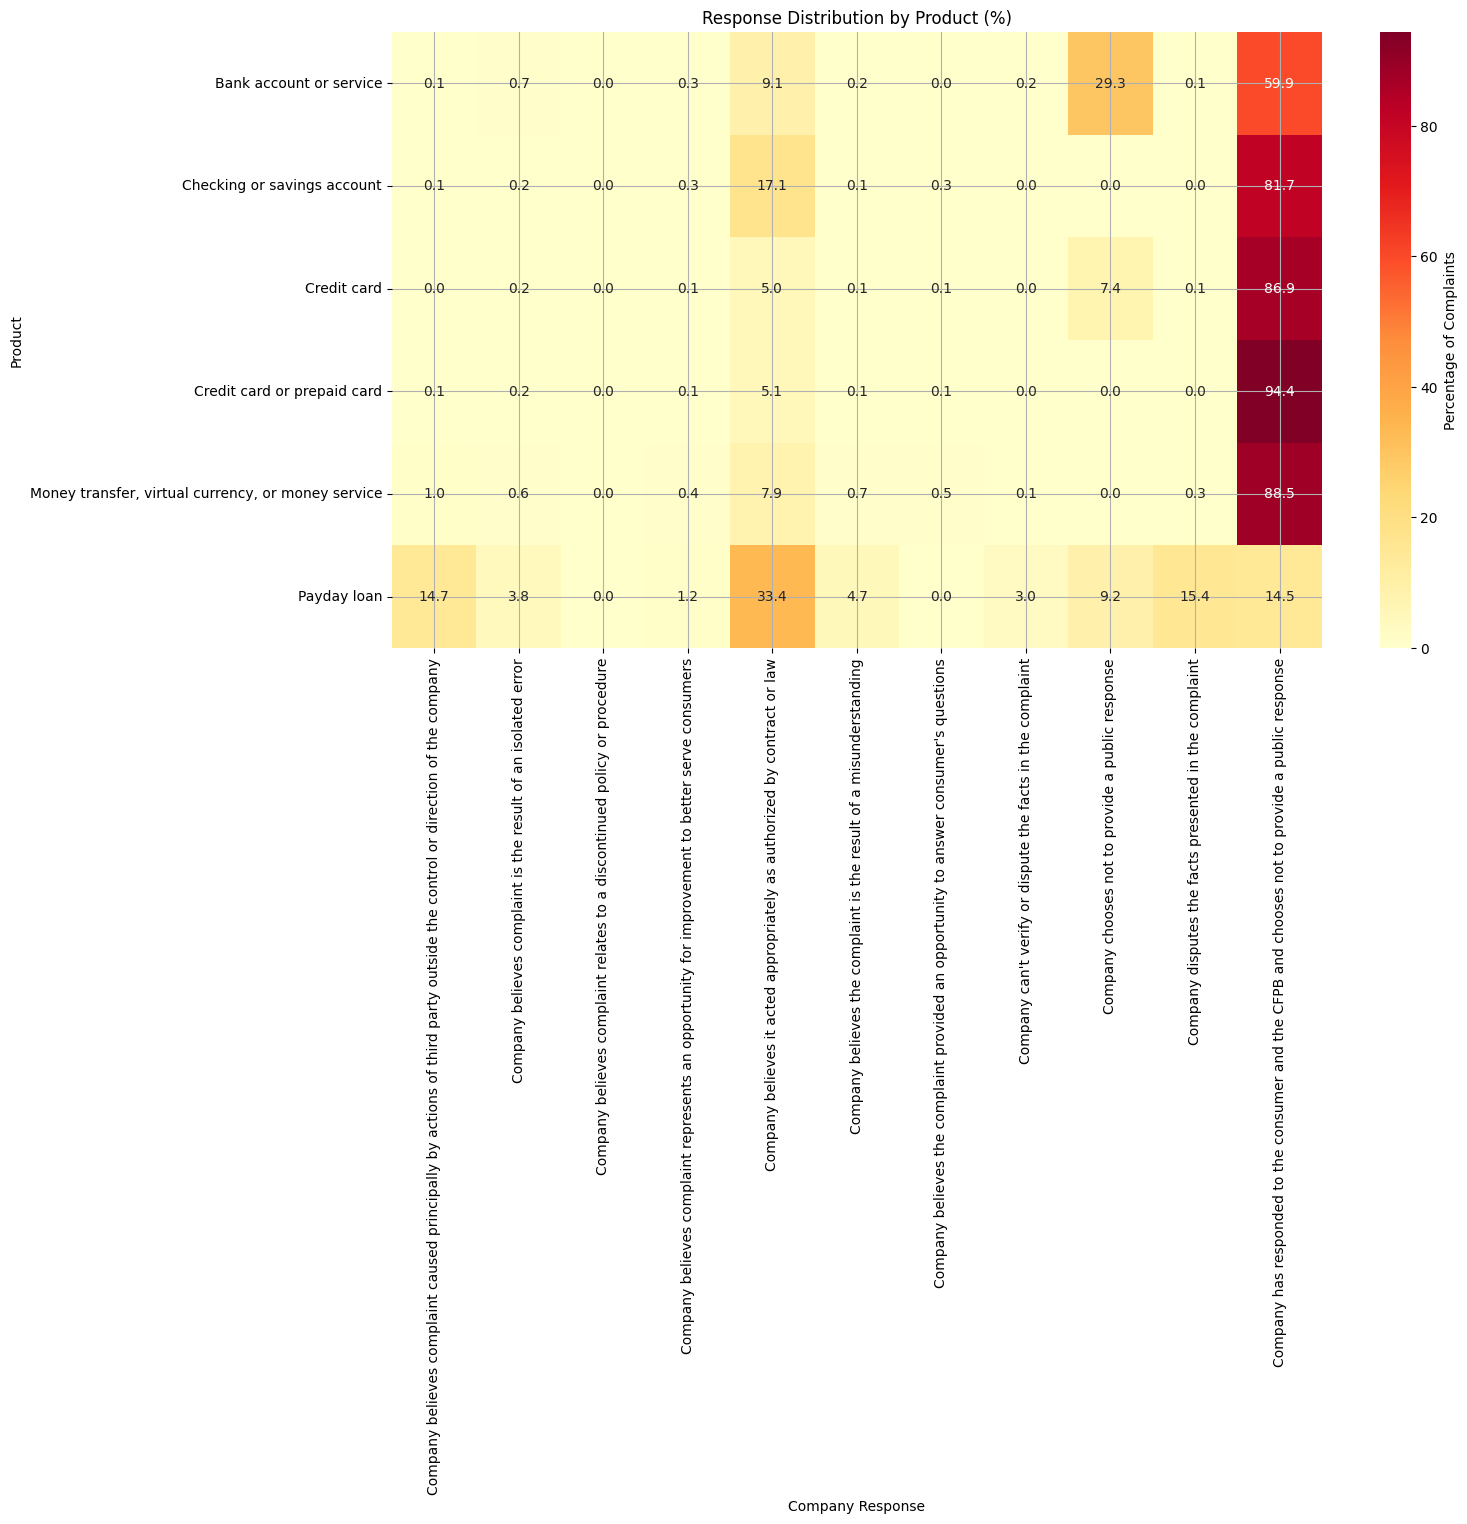


Summary Statistics:
--------------------------------------------------
Total number of complaints analyzed: 443,472
Number of unique products: 6
Number of unique sub-products: 25
Number of unique issues: 87
Number of unique companies: 1511
Number of states represented: 62
Date range: 2015-03-19 to 2025-06-15


In [41]:
### 2.4 Geographic and Response Analysis

print("Geographic and Response Analysis")
print("-" * 50)

# State distribution
state_dist = df_processed['State'].value_counts()
state_pct = df_processed['State'].value_counts(normalize=True) * 100

print("\nTop 10 States by Number of Complaints:")
for state, count in state_dist.head(10).items():
    pct = state_pct[state]
    print(f"{state}: {count:,} complaints ({pct:.1f}%)")

# Visualize state distribution
plt.figure(figsize=(15, 6))
state_dist.head(20).plot(kind='bar')
plt.title('Top 20 States by Number of Complaints')
plt.xlabel('State')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Company response analysis
response_dist = df_processed['Company public response'].value_counts()
response_pct = df_processed['Company public response'].value_counts(normalize=True) * 100

print("\nCompany Response Distribution:")
for response, count in response_dist.items():
    pct = response_pct[response]
    print(f"{response}: {count:,} responses ({pct:.1f}%)")

# Visualize response distribution
plt.figure(figsize=(10, 6))
response_dist.plot(kind='bar')
plt.title('Distribution of Company Public Responses')
plt.xlabel('Response Type')
plt.ylabel('Number of Responses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Response analysis by product
print("\nResponse Distribution by Product:")
print("-" * 50)
response_by_product = pd.crosstab(df_processed['Product'], df_processed['Company public response'], normalize='index') * 100
print(response_by_product.round(2))

# Visualize response distribution by product
plt.figure(figsize=(15, 8))
sns.heatmap(response_by_product, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Percentage of Complaints'})
plt.title('Response Distribution by Product (%)')
plt.xlabel('Company Response')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print(f"Total number of complaints analyzed: {len(df_processed):,}")
print(f"Number of unique products: {df_processed['Product'].nunique()}")
print(f"Number of unique sub-products: {df_processed['Sub-product'].nunique()}")
print(f"Number of unique issues: {df_processed['Issue'].nunique()}")
print(f"Number of unique companies: {df_processed['Company'].nunique()}")
print(f"Number of states represented: {df_processed['State'].nunique()}")
print(f"Date range: {df_processed['Date received'].min().date()} to {df_processed['Date received'].max().date()}")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mikiyasegaye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikiyasegaye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mikiyasegaye/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mikiyasegaye/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



NLTK resources successfully downloaded and tested!
Basic Text Statistics
--------------------------------------------------
Total complaints: 443,472
Complaints with narratives: 443,472 (100.0%)

Narrative Length Statistics:
Average length: 1188 characters
Maximum length: 41,712 characters
Minimum length: 4 characters


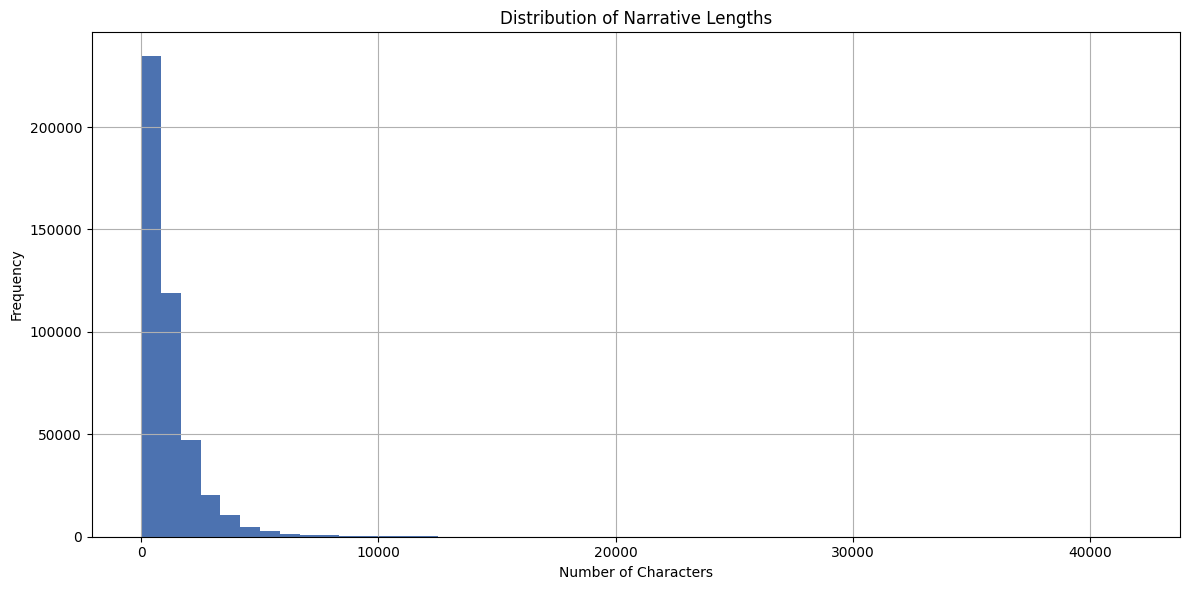


Sentence Statistics:
Average sentences per complaint: 9.7
Maximum sentences in a complaint: 441

Word Statistics:
Average words per complaint: 225.2
Maximum words in a complaint: 6914
Minimum words in a complaint: 1


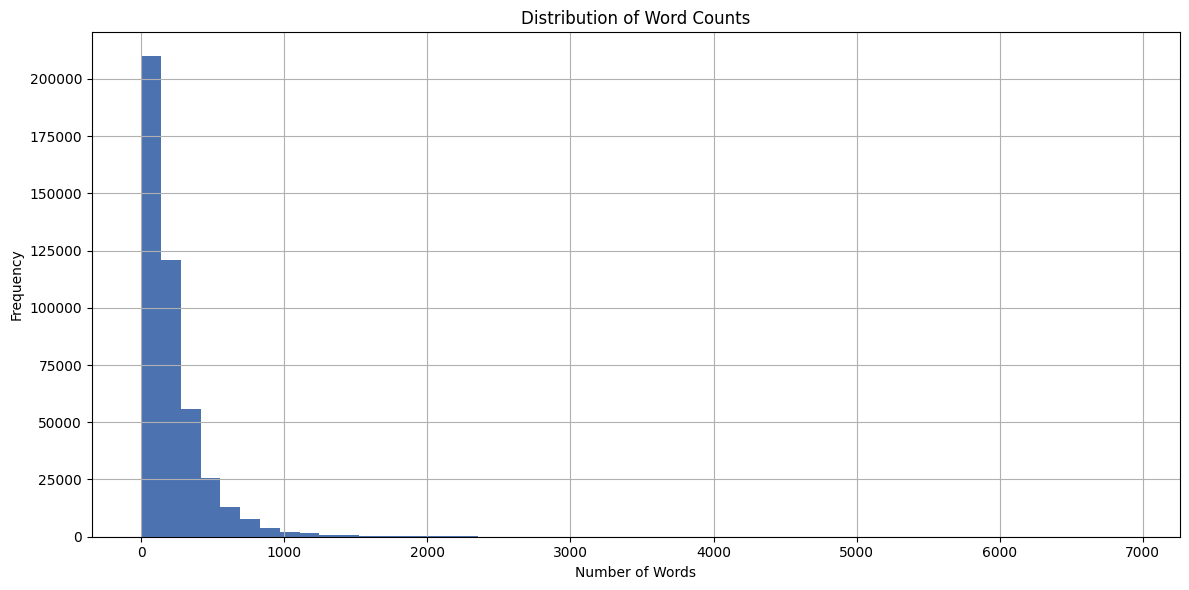

In [45]:
# Import additional required packages
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import re
from textblob import TextBlob

# Download all required NLTK data
print("Downloading required NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

# Verify the downloads
try:
    # Test tokenization
    test_text = "This is a test sentence. This is another one."
    sent_tokenize(test_text)
    word_tokenize(test_text)
    print("\nNLTK resources successfully downloaded and tested!")
except LookupError as e:
    print("\nError: Some NLTK resources are missing. Please run the downloads again.")
    raise e

# Get the narrative column
narrative_col = 'Consumer complaint narrative'
clean_narratives = df_processed[df_processed['clean_narrative'].notna()]['clean_narrative']

print("Basic Text Statistics")
print("-" * 50)

# Overall statistics
total_complaints = len(df_processed)
complaints_with_narratives = len(clean_narratives)
avg_length = clean_narratives.str.len().mean()
max_length = clean_narratives.str.len().max()
min_length = clean_narratives.str.len().min()

print(f"Total complaints: {total_complaints:,}")
print(f"Complaints with narratives: {complaints_with_narratives:,} ({complaints_with_narratives/total_complaints:.1%})")
print(f"\nNarrative Length Statistics:")
print(f"Average length: {avg_length:.0f} characters")
print(f"Maximum length: {max_length:,} characters")
print(f"Minimum length: {min_length:,} characters")

# Length distribution visualization
plt.figure(figsize=(12, 6))
clean_narratives.str.len().hist(bins=50)
plt.title('Distribution of Narrative Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Sentence statistics
sentence_counts = clean_narratives.apply(lambda x: len(sent_tokenize(x)))
avg_sentences = sentence_counts.mean()
max_sentences = sentence_counts.max()

print(f"\nSentence Statistics:")
print(f"Average sentences per complaint: {avg_sentences:.1f}")
print(f"Maximum sentences in a complaint: {max_sentences:.0f}")

# Word statistics
word_counts = clean_narratives.apply(lambda x: len(word_tokenize(x)))
avg_words = word_counts.mean()
max_words = word_counts.max()
min_words = word_counts.min()

print(f"\nWord Statistics:")
print(f"Average words per complaint: {avg_words:.1f}")
print(f"Maximum words in a complaint: {max_words:.0f}")
print(f"Minimum words in a complaint: {min_words:.0f}")

# Visualize word count distribution
plt.figure(figsize=(12, 6))
word_counts.hist(bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Word Frequency Analysis
--------------------------------------------------

Top 20 Most Common Words:
redacted: 3,198,165
account: 992,898
bank: 527,022
card: 500,662
credit: 482,941
would: 312,135
money: 281,560
told: 264,024
called: 226,260
received: 222,574
payment: 208,633
back: 204,454
one: 201,844
funds: 189,037
time: 186,812
said: 179,695
never: 169,522
information: 168,573
fraud: 168,421
check: 167,103


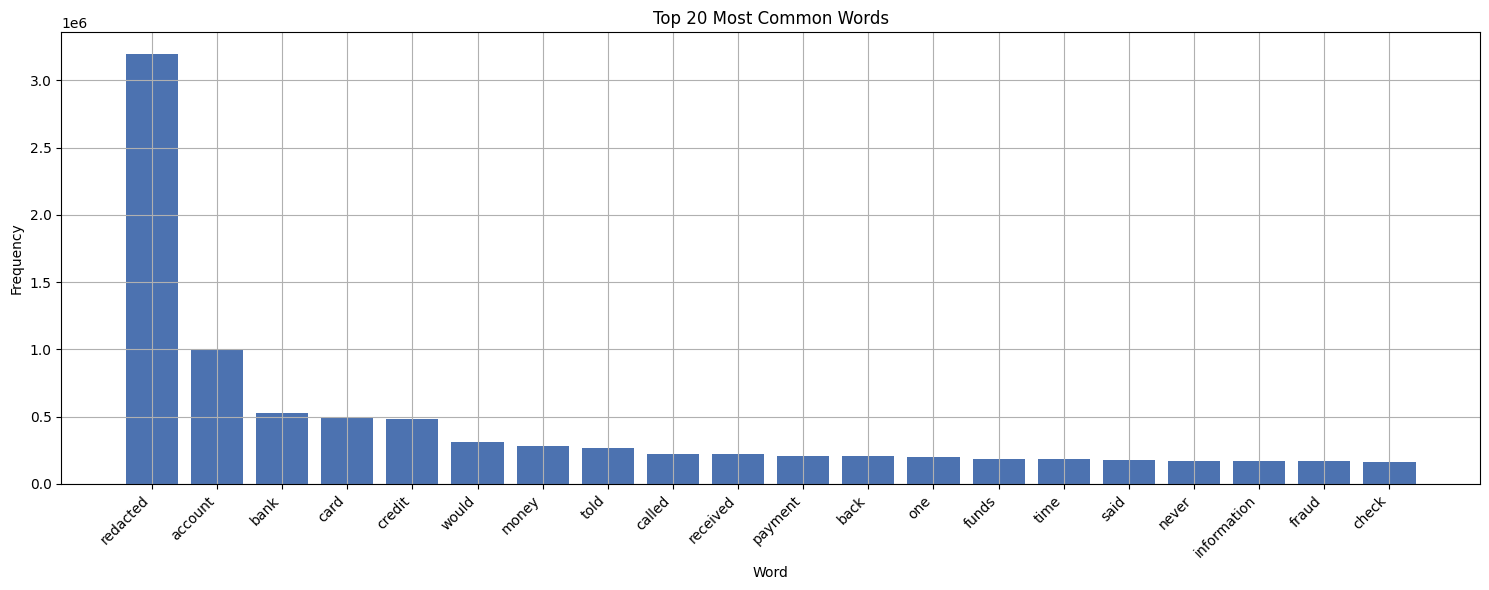


Top 15 Most Common Phrases (Bigrams):
redacted redacted: 1,472,707
credit card: 176,240
customer service: 101,780
wells fargo: 81,637
capital one: 76,507
bank america: 73,116
cash app: 72,952
checking account: 68,980
account redacted: 48,657
redacted account: 43,975
bank account: 41,774
debit card: 40,531
financial protection: 34,535
consumer financial: 34,139
account closed: 32,759

Top 5 Words by Product:

Credit card:
  - redacted: 603,849
  - credit: 170,356
  - card: 147,102
  - account: 132,979
  - payment: 65,343

Checking or savings account:
  - redacted: 1,127,414
  - account: 451,922
  - bank: 263,016
  - money: 131,407
  - would: 110,438

Money transfer, virtual currency, or money service:
  - redacted: 548,988
  - account: 168,950
  - money: 85,553
  - financial: 76,636
  - bank: 75,971

Credit card or prepaid card:
  - redacted: 791,348
  - card: 244,292
  - credit: 230,109
  - account: 189,023
  - bank: 92,301

Bank account or service:
  - redacted: 118,369
  - account: 

In [46]:
### 3.2 Word Frequency Analysis

print("Word Frequency Analysis")
print("-" * 50)

# Get stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['REDACTED', 'XX', 'XXX', 'XXXX'])  # Add custom stopwords

# Function to process text
def process_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords, punctuation, and numbers
    tokens = [word for word in tokens 
             if word.isalpha() 
             and word not in stop_words 
             and len(word) > 2]
    return tokens

# Process all narratives
all_words = []
for narrative in clean_narratives:
    all_words.extend(process_text(narrative))

# Get word frequencies
word_freq = Counter(all_words)

# Print top words
print("\nTop 20 Most Common Words:")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count:,}")

# Visualize top words
plt.figure(figsize=(15, 6))
words, counts = zip(*word_freq.most_common(20))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze bigrams
print("\nTop 15 Most Common Phrases (Bigrams):")
bigrams = []
for narrative in clean_narratives:
    tokens = process_text(narrative)
    bigrams.extend(list(ngrams(tokens, 2)))

bigram_freq = Counter(bigrams)
for bigram, count in bigram_freq.most_common(15):
    print(f"{' '.join(bigram)}: {count:,}")

# Word frequency by product
print("\nTop 5 Words by Product:")
for product in df_processed['Product'].unique():
    print(f"\n{product}:")
    product_narratives = df_processed[df_processed['Product'] == product]['clean_narrative'].dropna()
    
    # Process words for this product
    product_words = []
    for narrative in product_narratives:
        product_words.extend(process_text(narrative))
    
    # Get frequencies
    product_freq = Counter(product_words)
    for word, count in product_freq.most_common(5):
        print(f"  - {word}: {count:,}")


Sentiment Analysis
--------------------------------------------------

Sentiment Statistics:
Average Polarity: -0.001 (-1 = most negative, 1 = most positive)
Average Subjectivity: 0.390 (0 = most objective, 1 = most subjective)


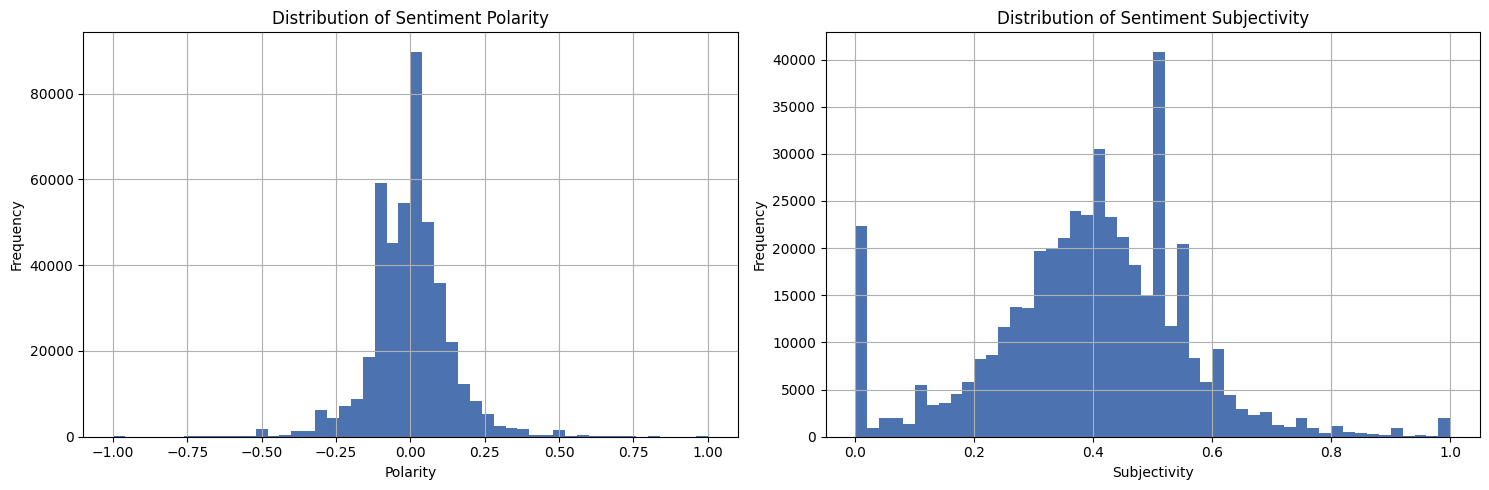


Average Sentiment by Product:

Credit card:
  Average Polarity: 0.008
  Average Subjectivity: 0.404

Checking or savings account:
  Average Polarity: 0.006
  Average Subjectivity: 0.360

Money transfer, virtual currency, or money service:
  Average Polarity: -0.025
  Average Subjectivity: 0.426

Credit card or prepaid card:
  Average Polarity: 0.004
  Average Subjectivity: 0.390

Bank account or service:
  Average Polarity: 0.015
  Average Subjectivity: 0.383

Payday loan:
  Average Polarity: 0.011
  Average Subjectivity: 0.365

Common Text Patterns
--------------------------------------------------

Common Patterns in Narratives:
Contains Amount: 183,268 (41.3%)
Mentions Date: 155 (0.0%)
Has Phone Number: 20 (0.0%)
Has Email: 106 (0.0%)
Mentions Account: 330,831 (74.6%)
Mentions Payment: 185,335 (41.8%)
Mentions Credit: 178,376 (40.2%)
Mentions Fraud: 153,541 (34.6%)


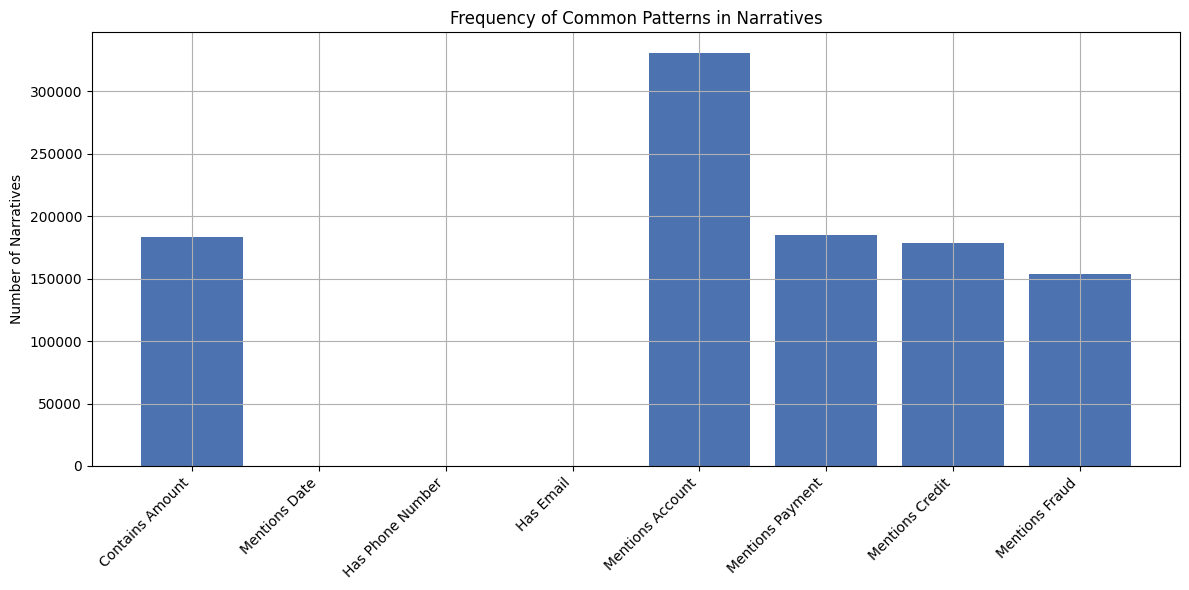

In [47]:
### 3.3 Sentiment Analysis and Common Patterns

print("Sentiment Analysis")
print("-" * 50)

# Function to get sentiment scores
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Calculate sentiment for all narratives
sentiments = clean_narratives.apply(get_sentiment)
polarities = sentiments.apply(lambda x: x[0])
subjectivities = sentiments.apply(lambda x: x[1])

# Print sentiment statistics
print("\nSentiment Statistics:")
print(f"Average Polarity: {polarities.mean():.3f} (-1 = most negative, 1 = most positive)")
print(f"Average Subjectivity: {subjectivities.mean():.3f} (0 = most objective, 1 = most subjective)")

# Visualize sentiment distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(polarities, bins=50)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(subjectivities, bins=50)
plt.title('Distribution of Sentiment Subjectivity')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Sentiment by product
print("\nAverage Sentiment by Product:")
for product in df_processed['Product'].unique():
    product_narratives = df_processed[df_processed['Product'] == product]['clean_narrative'].dropna()
    product_sentiments = product_narratives.apply(get_sentiment)
    avg_polarity = np.mean([s[0] for s in product_sentiments])
    avg_subjectivity = np.mean([s[1] for s in product_sentiments])
    print(f"\n{product}:")
    print(f"  Average Polarity: {avg_polarity:.3f}")
    print(f"  Average Subjectivity: {avg_subjectivity:.3f}")

# Common patterns analysis
print("\nCommon Text Patterns")
print("-" * 50)

# Function to find common patterns
def extract_patterns(text):
    patterns = {
        'contains_amount': bool(re.search(r'\$\d+', text)),
        'mentions_date': bool(re.search(r'\d{1,2}/\d{1,2}/\d{2,4}', text)),
        'has_phone_number': bool(re.search(r'\d{3}[-.]?\d{3}[-.]?\d{4}', text)),
        'has_email': bool(re.search(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', text)),
        'mentions_account': bool(re.search(r'account|acct', text.lower())),
        'mentions_payment': bool(re.search(r'payment|paid|pay', text.lower())),
        'mentions_credit': bool(re.search(r'credit|score', text.lower())),
        'mentions_fraud': bool(re.search(r'fraud|scam|theft', text.lower())),
    }
    return patterns

# Analyze patterns in narratives
pattern_results = {k: 0 for k in ['contains_amount', 'mentions_date', 'has_phone_number', 
                                 'has_email', 'mentions_account', 'mentions_payment',
                                 'mentions_credit', 'mentions_fraud']}

for narrative in clean_narratives:
    patterns = extract_patterns(narrative)
    for k, v in patterns.items():
        if v:
            pattern_results[k] += 1

# Print pattern statistics
print("\nCommon Patterns in Narratives:")
for pattern, count in pattern_results.items():
    percentage = (count / len(clean_narratives)) * 100
    print(f"{pattern.replace('_', ' ').title()}: {count:,} ({percentage:.1f}%)")

# Visualize patterns
plt.figure(figsize=(12, 6))
patterns = list(pattern_results.keys())
counts = list(pattern_results.values())
plt.bar(range(len(patterns)), counts)
plt.xticks(range(len(patterns)), [p.replace('_', ' ').title() for p in patterns], rotation=45, ha='right')
plt.title('Frequency of Common Patterns in Narratives')
plt.ylabel('Number of Narratives')
plt.tight_layout()
plt.show()


Redaction Analysis
--------------------------------------------------

Redaction Statistics:
Total REDACTED occurrences: 4,941,600
Total XX+ occurrences: 0

Average REDACTED per narrative: 11.14
Average XX+ per narrative: 0.00


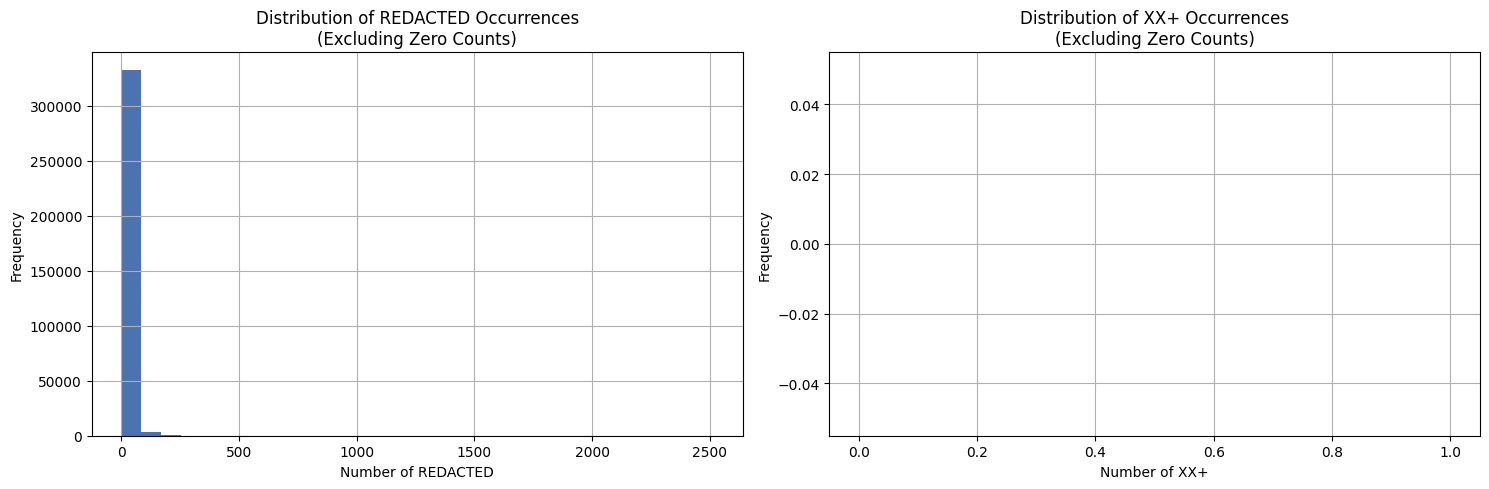


Redaction Statistics by Product:

Credit card:
  Average REDACTED per narrative: 10.98
  Average XX+ per narrative: 0.00

Checking or savings account:
  Average REDACTED per narrative: 12.53
  Average XX+ per narrative: 0.00

Money transfer, virtual currency, or money service:
  Average REDACTED per narrative: 7.92
  Average XX+ per narrative: 0.00

Credit card or prepaid card:
  Average REDACTED per narrative: 12.53
  Average XX+ per narrative: 0.00

Bank account or service:
  Average REDACTED per narrative: 10.49
  Average XX+ per narrative: 0.00

Payday loan:
  Average REDACTED per narrative: 6.18
  Average XX+ per narrative: 0.00

Common Contexts of Redactions:

Sample redaction contexts:
  - In REDACTED REDACTED files a
  - In REDACTED REDACTED files a claim
  - talked to a REDACTED from texas he
  - after REDACTED/REDACTED/REDACTED after REDACTED REDACTED so i
  - REDACTED/REDACTED/REDACTED after REDACTED REDACTED so i did


In [48]:
### 3.4 Redaction Analysis

print("Redaction Analysis")
print("-" * 50)

# Function to analyze redactions
def analyze_redactions(text):
    redacted_count = len(re.findall(r'REDACTED', text))
    xx_count = len(re.findall(r'XX+', text))
    return redacted_count, xx_count

# Calculate redaction statistics
redaction_stats = clean_narratives.apply(analyze_redactions)
redacted_counts = redaction_stats.apply(lambda x: x[0])
xx_counts = redaction_stats.apply(lambda x: x[1])

# Print redaction statistics
print("\nRedaction Statistics:")
print(f"Total REDACTED occurrences: {redacted_counts.sum():,}")
print(f"Total XX+ occurrences: {xx_counts.sum():,}")
print(f"\nAverage REDACTED per narrative: {redacted_counts.mean():.2f}")
print(f"Average XX+ per narrative: {xx_counts.mean():.2f}")

# Visualize redaction distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(redacted_counts[redacted_counts > 0], bins=30)
plt.title('Distribution of REDACTED Occurrences\n(Excluding Zero Counts)')
plt.xlabel('Number of REDACTED')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(xx_counts[xx_counts > 0], bins=30)
plt.title('Distribution of XX+ Occurrences\n(Excluding Zero Counts)')
plt.xlabel('Number of XX+')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Redaction analysis by product
print("\nRedaction Statistics by Product:")
for product in df_processed['Product'].unique():
    print(f"\n{product}:")
    product_narratives = df_processed[df_processed['Product'] == product]['clean_narrative'].dropna()
    product_redactions = product_narratives.apply(analyze_redactions)
    avg_redacted = np.mean([r[0] for r in product_redactions])
    avg_xx = np.mean([r[1] for r in product_redactions])
    print(f"  Average REDACTED per narrative: {avg_redacted:.2f}")
    print(f"  Average XX+ per narrative: {avg_xx:.2f}")

# Context analysis
print("\nCommon Contexts of Redactions:")
def get_redaction_context(text, window=3):
    words = text.split()
    contexts = []
    for i, word in enumerate(words):
        if word == 'REDACTED':
            start = max(0, i - window)
            end = min(len(words), i + window + 1)
            context = ' '.join(words[start:end])
            contexts.append(context)
    return contexts

# Get sample contexts
all_contexts = []
for narrative in clean_narratives.sample(min(1000, len(clean_narratives))):
    all_contexts.extend(get_redaction_context(narrative))

print("\nSample redaction contexts:")
for context in all_contexts[:5]:
    print(f"  - {context}")
